In [1]:
import numpy as np
import pandas as pd
# REGEX PATTERNS FOR THE PATIENTS IDS
REGEX = r'(^\S+-.+-\S)|(Reporter intensity corrected)|(^P\d{6}$)'  # patient identifiers
Z_SCORE_REGEX = r'(^\S+-.+-\S)|(Reporter intensity corrected)|(^P\d{6}$) Z-score'
REGEX_META = r'^Identification metadata'  # to get num identified pepetides in FP intensity file

def count_df_to_density_plot_df(temp_df,identifier):
    # background = pd.DataFrame(temp_fpkm.filter(regex = cn.REGEX).to_numpy().flatten())
    background = temp_df.filter(regex = REGEX).to_numpy().flatten()
    backgournd_count_df = data_to_count_df(background,color='blue',opacity= 0.15)
    abundances = temp_df[temp_df.index == identifier]
    abundances =  abundances.filter(regex=REGEX).to_numpy()
    abundances_count_df = data_to_count_df(abundances,color='red',opacity=0.8,density=False)
    final_count_df = pd.concat([backgournd_count_df,abundances_count_df])
    final_count_df = final_count_df.sort_values(by='X')
    return final_count_df


def data_to_count_df(data:np.array, color='red',bins = 50, opacity = 0.3, density = True):
    inp = data[~np.isnan(data)]
    inp = data[np.isfinite(data)]
    hs = np.histogram(inp, bins= bins, density=density)
    counts = np.interp(hs[0], (hs[0].min(), hs[0].max()), (0, +1))
    edges = np.round(hs[1][0:len(hs[1])-1],decimals=2)
    df = pd.DataFrame(list(zip(edges, counts)))
    df.columns = ['X','Y']
    df['color'] = color
    df['opacity'] = opacity
    df['ind'] = df['X']
    return df

def unnest_proteingroups(df:pd.DataFrame) -> pd.DataFrame:
    """
    Unnest the protein_groups A;B as two separate rows with the same values
    the protein groups are the index of the the pandas dataframe df
    """
    temp_df = df
    temp_df['index'] = temp_df.index.str.split(';')
    temp_df = temp_df.explode('index')
    temp_df = temp_df.set_index('index')
    return temp_df


def get_pep_number_from_protein_name(intensity_df:pd.DataFrame,protein_name:str,regex=REGEX_META) -> pd.DataFrame:
    """ 
    gets the number of the identified pepetides from the protein name across all the patients
    :intensity_df: A pandas dataframe of the intensities with Identification metadata columns for each patient 
    :protein_name: the name of the protein
    :USAGE :
        get_pep_number_from_protein_name(fp_df,'EGFR')

    """
    premeta_df = pd.DataFrame(intensity_df.loc[protein_name,:])
    premeta_df = premeta_df.filter(regex=regex,axis=0)
    premeta_df[protein_name] = premeta_df[protein_name].str.replace('num_peptides=|;','', regex=True)
    premeta_df[protein_name] = premeta_df[protein_name].str.replace('detected in batch','0', regex=True) 
    premeta_df[protein_name] = pd.to_numeric(premeta_df[protein_name])
    premeta_df['Sample name'] = premeta_df.index.str.replace('Identification metadata ','', regex=True)
    premeta_df.columns = ['num_pep','Sample name']
    return premeta_df


def get_protein_intensity_per_protein(intensity_df:pd.DataFrame,protein_name:str,regex=REGEX) -> pd.DataFrame:
    df = pd.DataFrame(intensity_df.loc[protein_name,:])
    return df.filter(regex=regex,axis=0)


def get_occurence_per_protein(intensity_df:pd.DataFrame,protein_name:str,regex=REGEX) -> pd.DataFrame:
    df = pd.DataFrame(intensity_df.loc[protein_name,:])
    df = df.filter(regex=regex,axis=0)
    df = df.dropna()
    return df.count()[protein_name]




In [2]:
from pathlib import Path
import pandas as pd
#report_dir = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.06.22_AhS_PAPER_COHORT'
report_dir = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.07.31_CJ_pancancer_123'
biomarker_main_list_df = pd.read_excel('/home/amir/Desktop/Annika_files/Biomarkerlist_for Plotting.xlsx')
biomarker_list_df = biomarker_main_list_df.copy()
biomarker_list_df = biomarker_list_df[['Gene name (uniprot)'	,'other name']]
biomarker_list_df['Gene name (uniprot)'] = biomarker_list_df['Gene name (uniprot)'].str.strip()

intensity_df_path = Path(report_dir)/ Path('preprocessed_fp.csv')
intensity_df = pd.read_csv(intensity_df_path).set_index('Gene names')

In [3]:
high_confident = biomarker_main_list_df['Gene name (uniprot)'][biomarker_main_list_df['high confident detection'] == 'x'].tolist()
low_confident = biomarker_main_list_df['Gene name (uniprot)'][biomarker_main_list_df['low confident detection (1 peptide, median raw intensity <6.5,  occurrence <20)'] == 'x'].tolist()

In [4]:
occurence = []
protein_names = []
median_pep_identified = []
median_intensity = []
for i in range(len(intensity_df.index)):
    protin_name = intensity_df.index[i] 
    median_pep_identified.append(get_pep_number_from_protein_name(intensity_df,protin_name)['num_pep'].median())
    median_intensity.append(get_protein_intensity_per_protein(intensity_df,protin_name)[protin_name].median())
    occurence.append(get_occurence_per_protein(intensity_df,protin_name))
    protein_names.append(protin_name)

num_pep_df = pd.DataFrame(list(zip(protein_names,median_pep_identified)),columns=['protein_names','no_peptides_identified'])
intensity_meidans_df = pd.DataFrame(list(zip(protein_names,median_intensity)),columns=['protein_names','log10[intensity]'])
occurence_df = pd.DataFrame(list(zip(protein_names,occurence)),columns=['protein_names','occurence'])
all_data = pd.DataFrame(list(zip(protein_names,median_pep_identified,median_intensity,occurence)),columns=['protein_names',
                                                                                                            'no_peptides_identified',
                                                                                                            'log10[intensity]',
                                                                                                            'occurence'])

common_genes = [x for x in biomarker_list_df['Gene name (uniprot)'].tolist() if x  in all_data['protein_names'].tolist() ]

/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/amir/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, ou

In [5]:
subset = all_data[all_data['protein_names'].isin(common_genes)]
final_df = subset.merge(biomarker_list_df,left_on='protein_names',right_on='Gene name (uniprot)',how='outer')
final_df.to_excel('/home/amir/Desktop/Annika_files/Biomarkerlist.xlsx',index=False)
all_data = all_data.rename(columns={'log10[intensity]':'intensity'})

In [6]:
subset.dropna(inplace=True)
subset = subset.rename(columns={'log10[intensity]':'intensity'})
subset['confidence'] = 'not'
subset['confidence'][subset['protein_names'].isin(high_confident)] = 'high'
subset['confidence'][subset['protein_names'].isin(low_confident)] = 'low'
main_subset = subset.copy()

/tmp/ipykernel_1132322/2139199073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['confidence'][subset['protein_names'].isin(high_confident)] = 'high'
/tmp/ipykernel_1132322/2139199073.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['confidence'][subset['protein_names'].isin(low_confident)] = 'low'


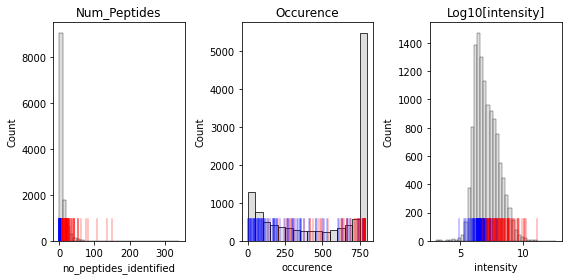

In [12]:

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns


plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True
fig, axes = plt.subplots(1,3)

im1 = sns.histplot(data=all_data, x="no_peptides_identified",binwidth=10,color='lightgrey',ax=axes[0])
im2 =sns.histplot(data=all_data, x="occurence",binwidth=50,color='lightgrey',ax=axes[1])
im3 =sns.histplot(data=all_data, x="intensity",binwidth=0.25,color='lightgrey',ax=axes[2])

im1.set(title = f'Num_Peptides')
im2.set(title = f'Occurence')
im3.set(title = f'Log10[intensity]')
for color,conf in zip(['red','blue'],['high','low']):
        subset = main_subset[main_subset['confidence'] == conf].reset_index()
        for i in range(len(subset)):
                protein = subset['protein_names'][i]

                no_pep = int(subset['no_peptides_identified'][subset['protein_names'] == protein])
                intensity = float(subset['intensity'][subset['protein_names'] == protein])
                occurence = int(subset['occurence'][subset['protein_names'] == protein])
                im1.axvline(x = no_pep, 
                        color = color,
                        alpha = 0.3,
                        ymin = 0, # Bottom of the plot
                        ymax = 0.1) # Top of the plot
                
                im2.axvline(x = occurence, 
                        color = color,
                        alpha = 0.3,
                        ymin = 0, # Bottom of the plot
                        ymax = 0.1) # Top of the plot
        
                im3.axvline(x = intensity, 
                        color = color,
                        alpha = 0.3,
                        ymin = 0, # Bottom of the plot
                        ymax = 0.1) # Top of the plot
              
        
fig.subplots_adjust(wspace=0.05, hspace=0)
mappable = im1.get_children()[0]
#fig.colorbar(mappable, ax = [patient,celllines],orientation = 'vertical')
#ps_names.to_excel('/home/amir/Desktop/Annika_files/pseudo_names.xlsx')
plt.savefig('/home/amir/Desktop/Annika_files/biomarker.svg')
plt.show()



# mulit page Seaborn plotting

/tmp/ipykernel_1132322/3889066835.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1,3)


<Figure size 576x288 with 0 Axes>

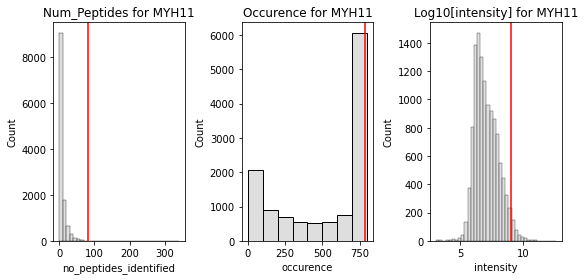

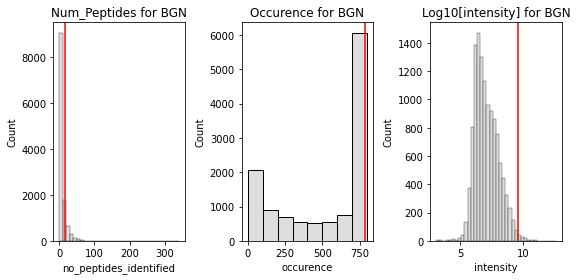

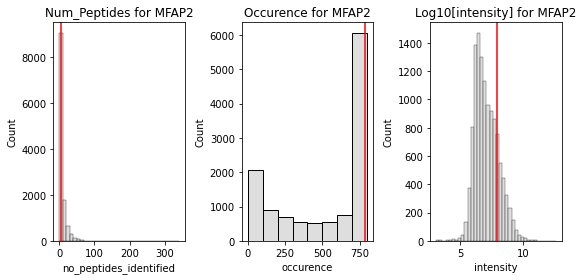

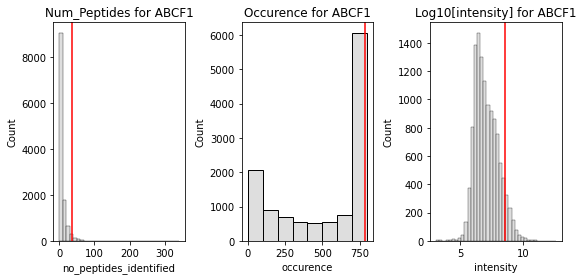

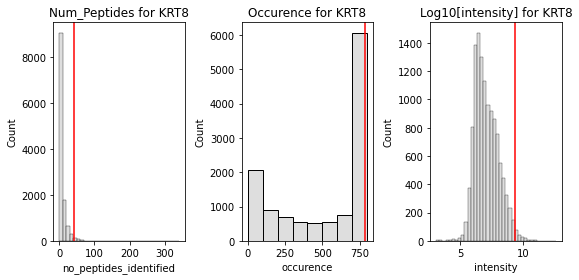

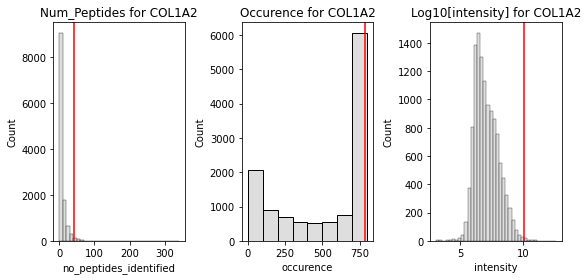

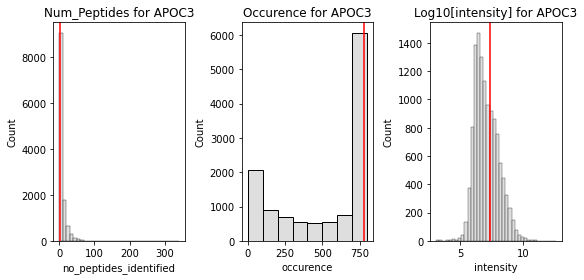

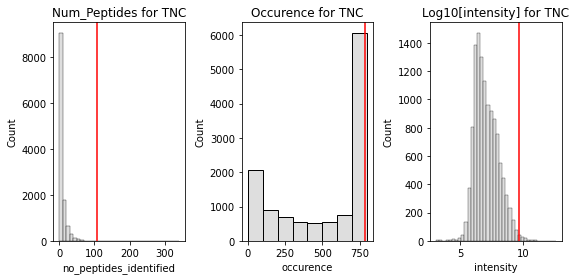

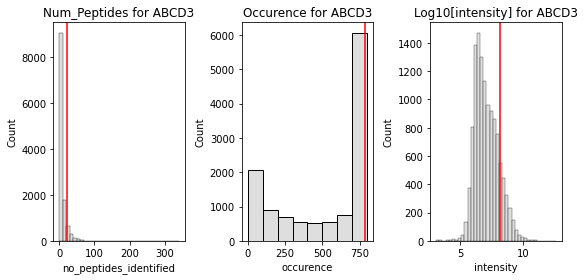

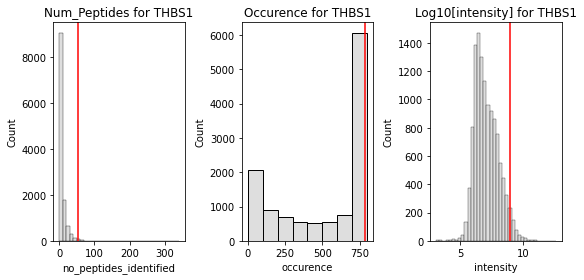

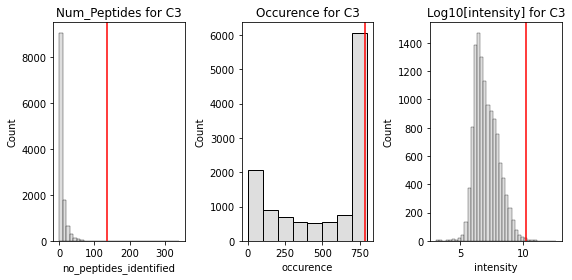

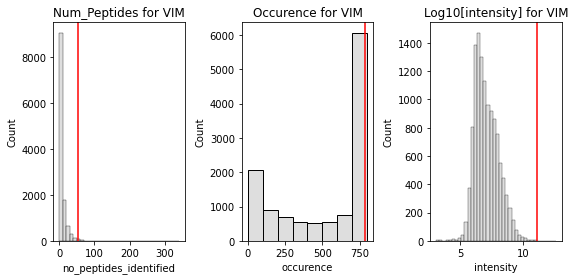

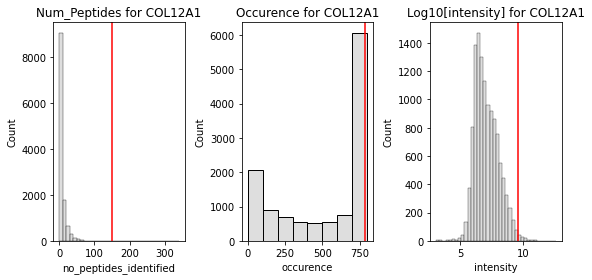

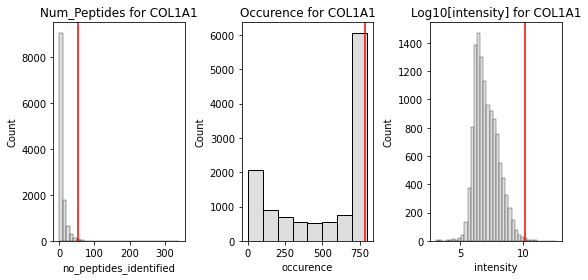

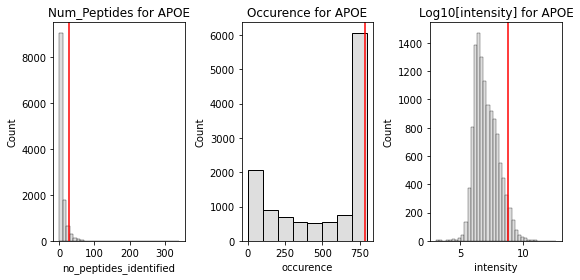

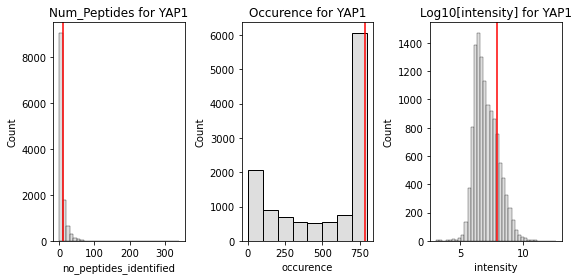

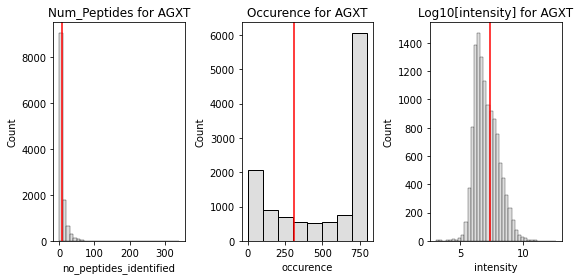

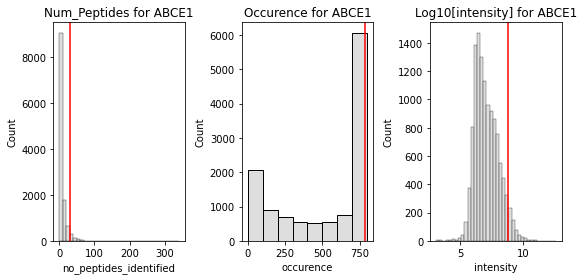

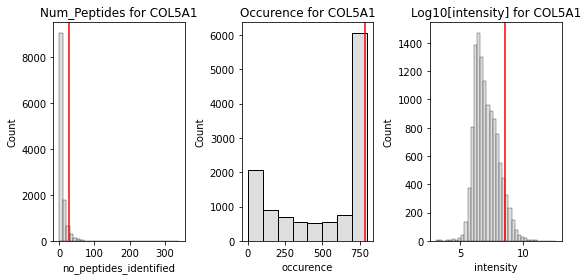

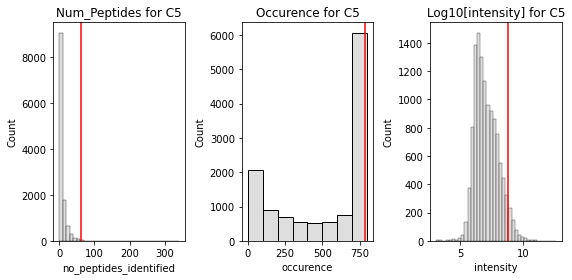

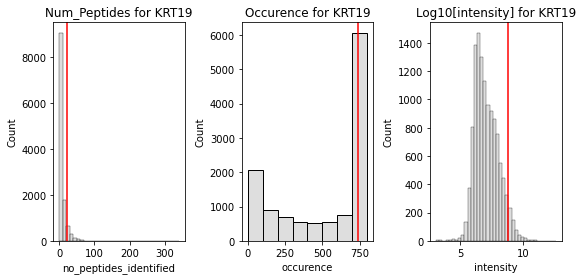

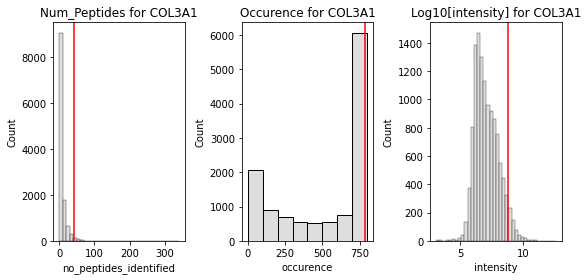

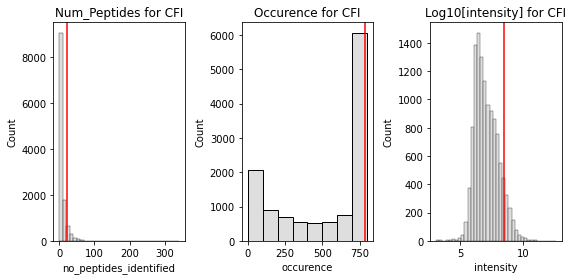

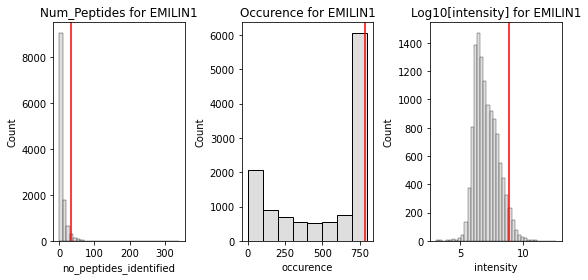

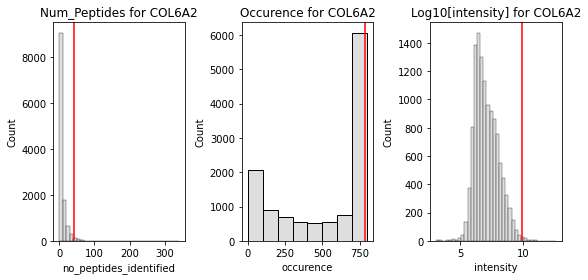

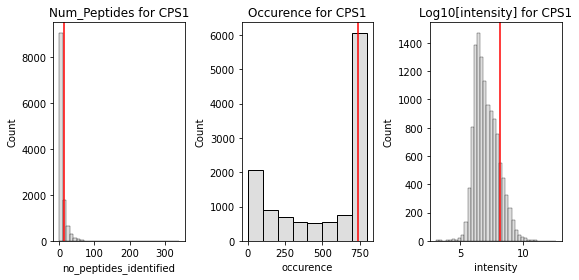

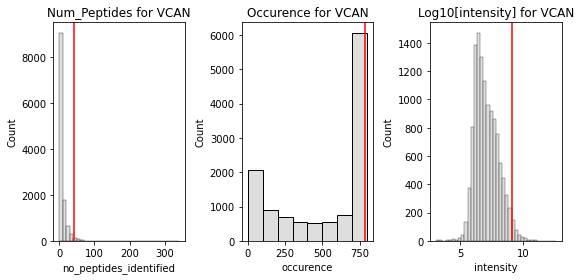

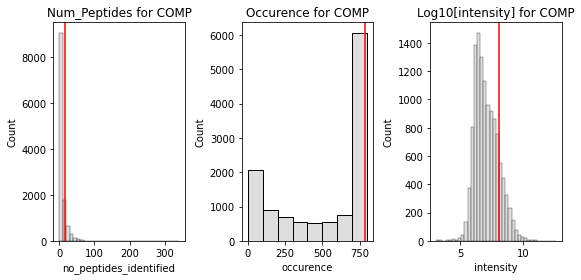

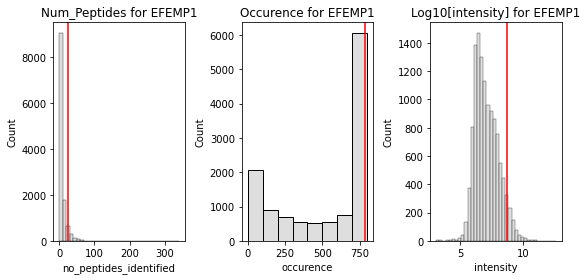

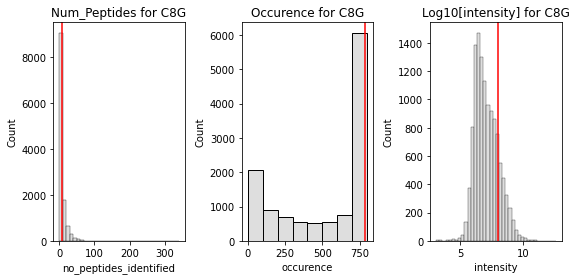

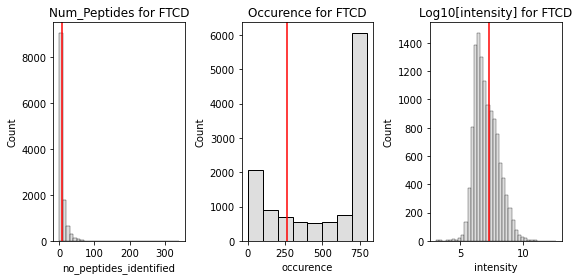

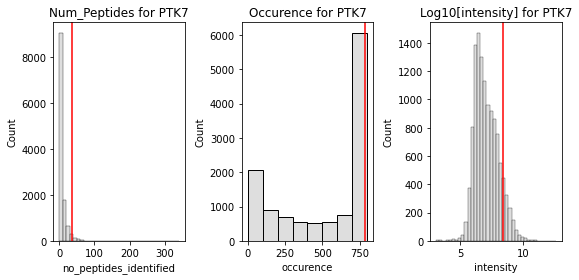

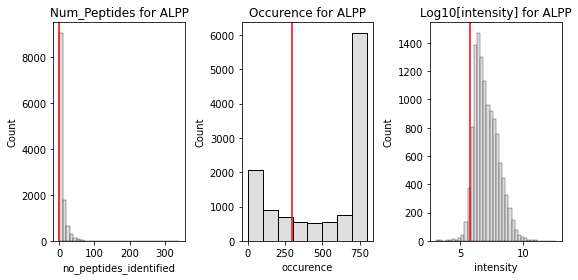

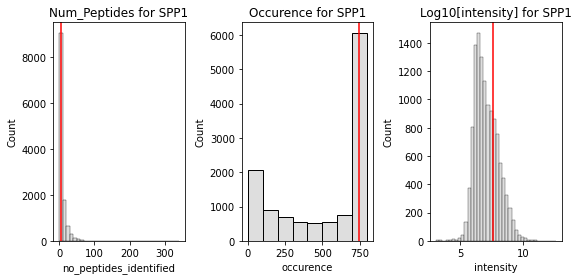

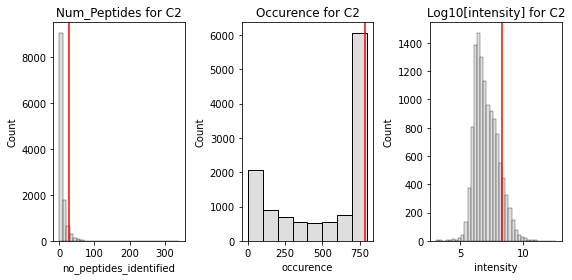

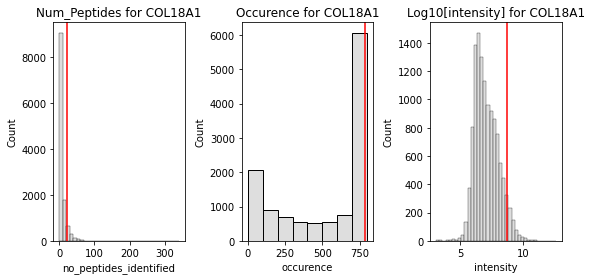

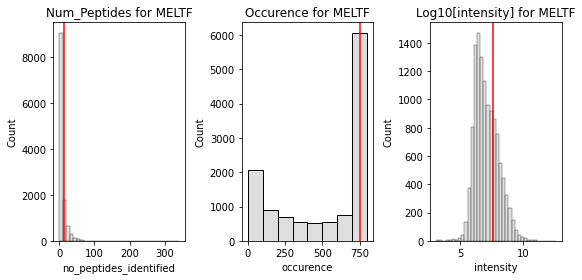

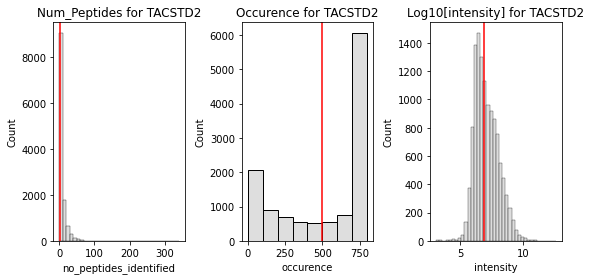

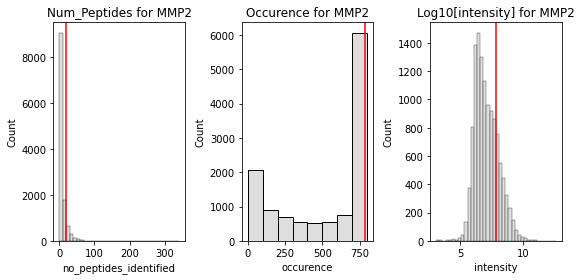

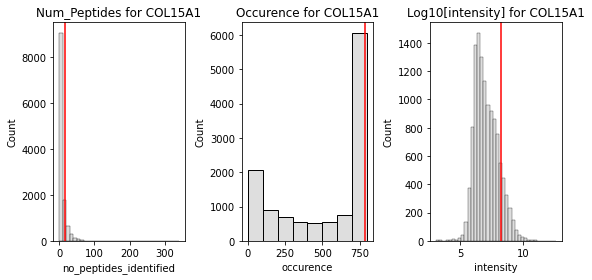

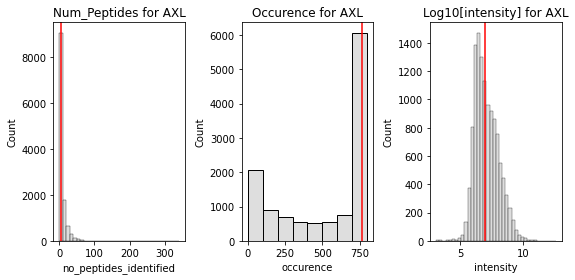

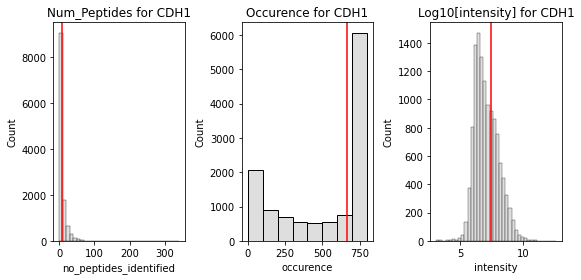

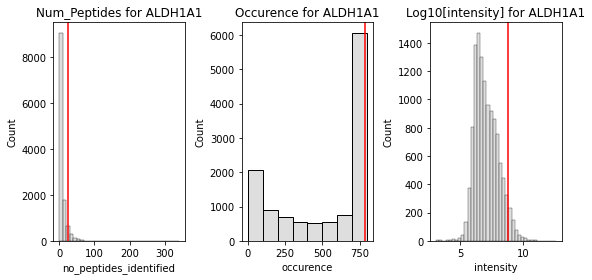

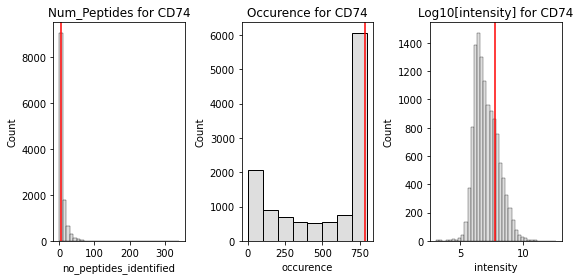

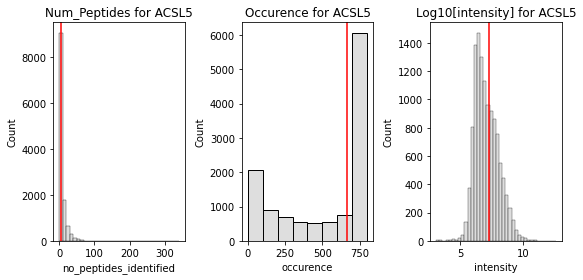

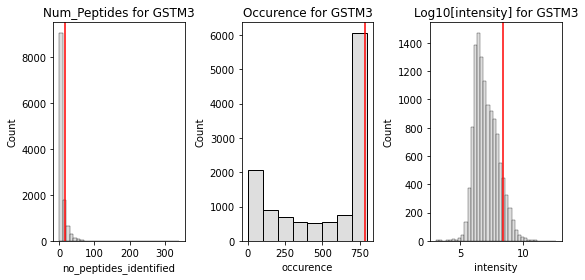

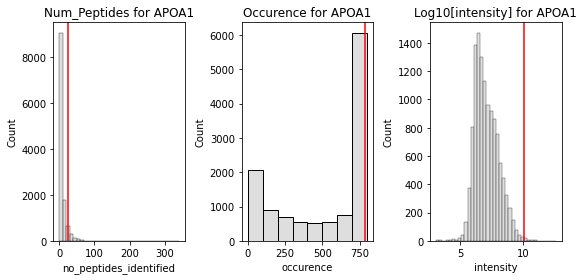

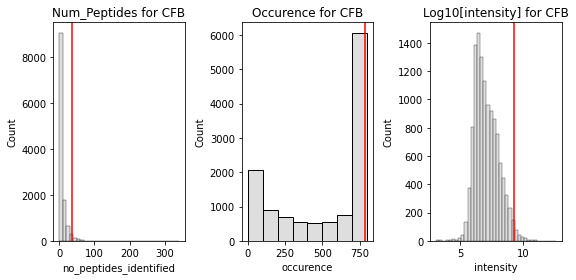

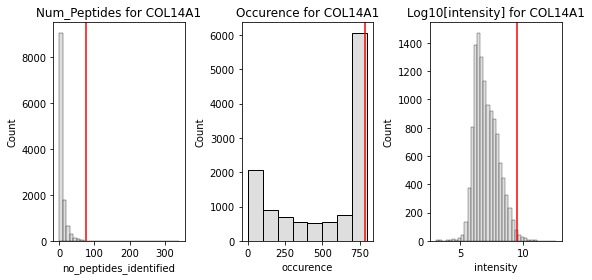

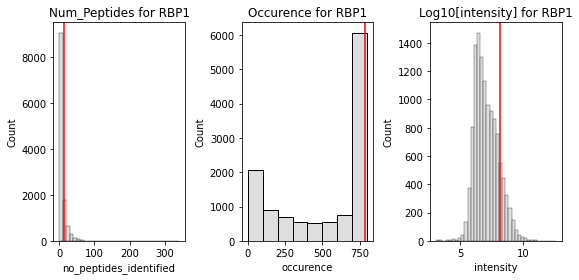

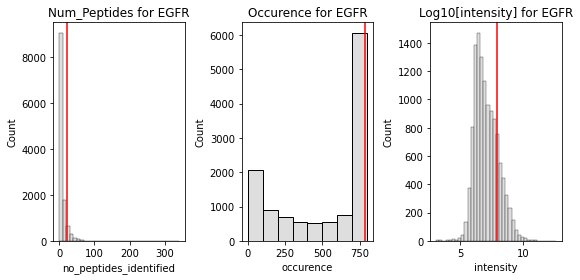

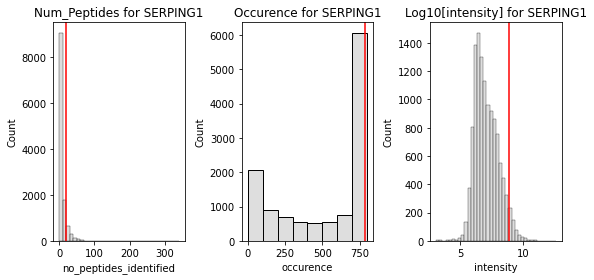

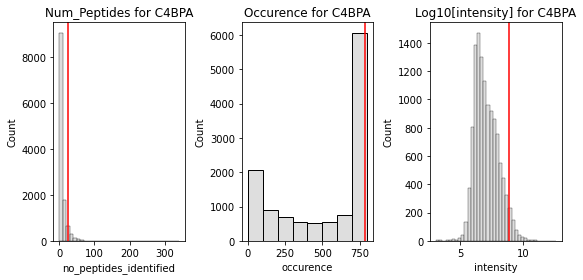

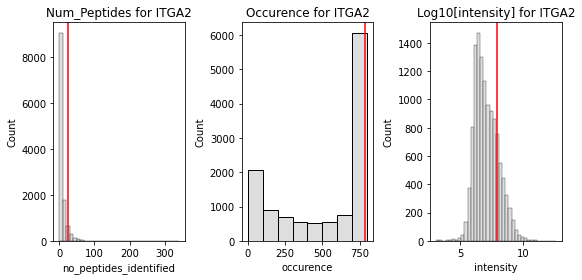

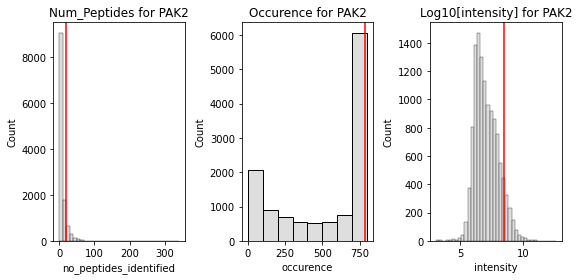

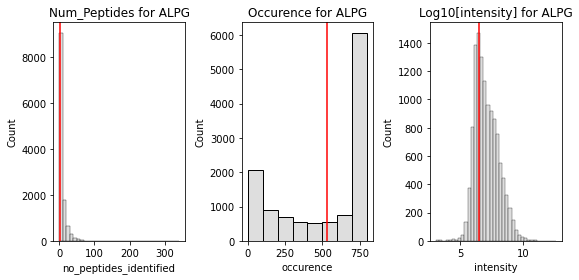

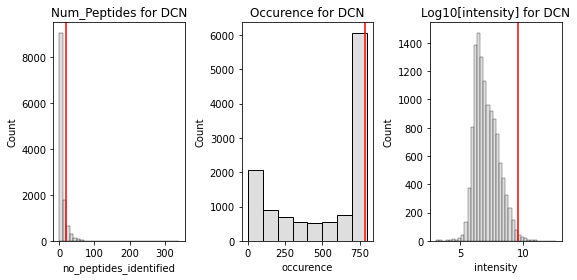

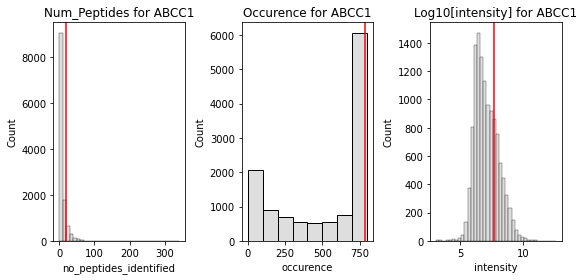

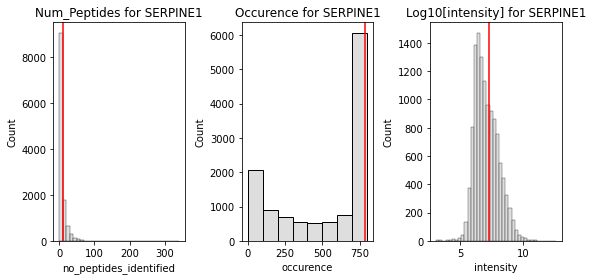

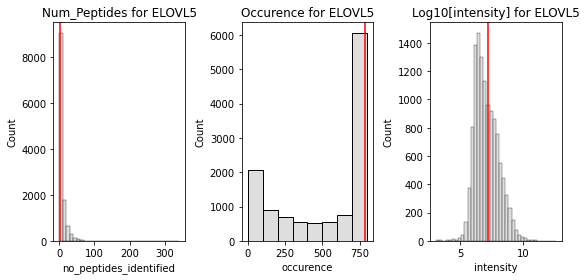

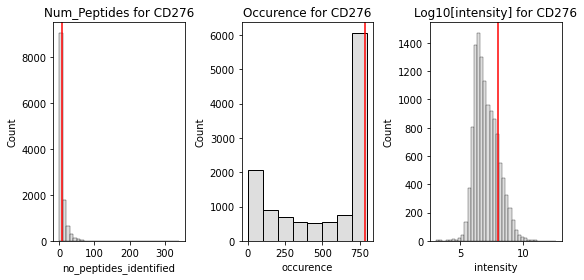

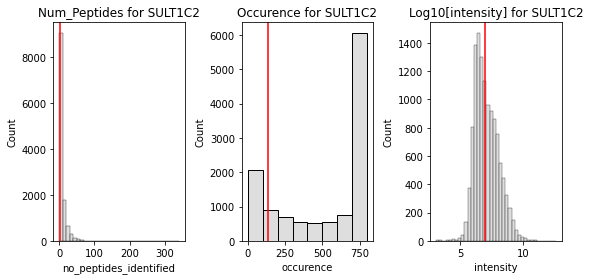

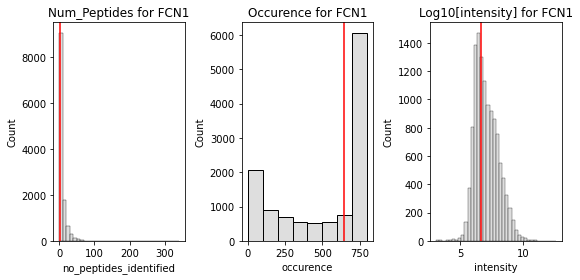

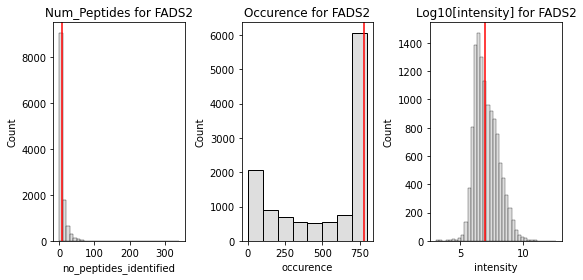

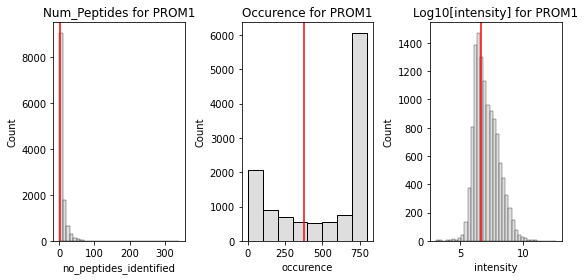

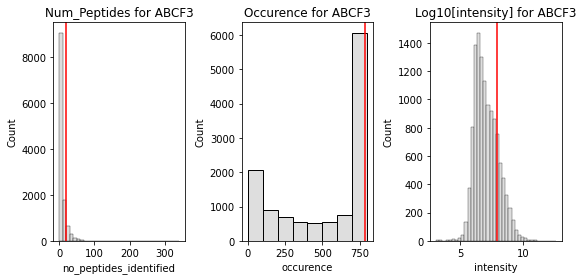

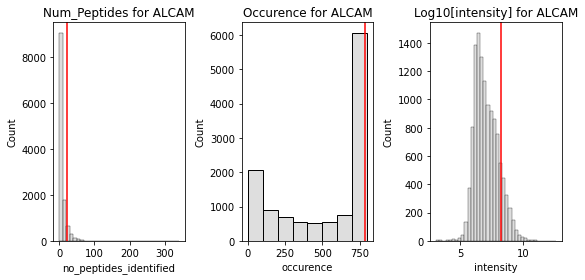

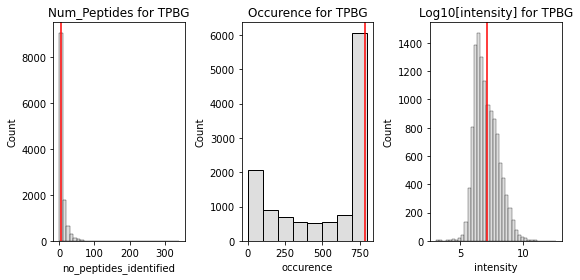

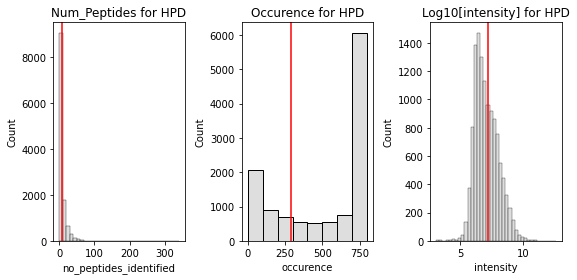

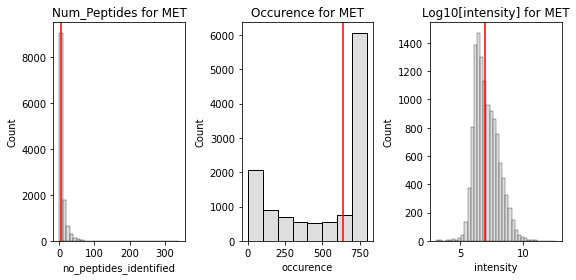

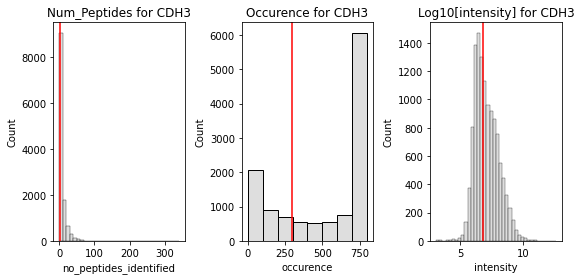

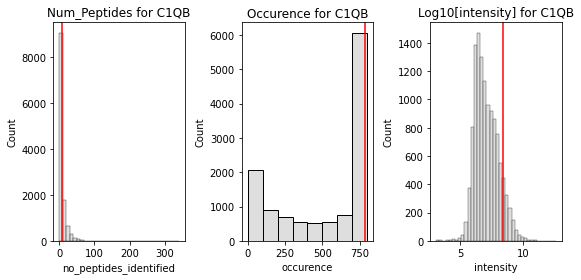

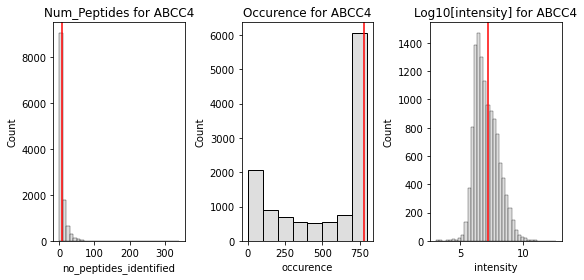

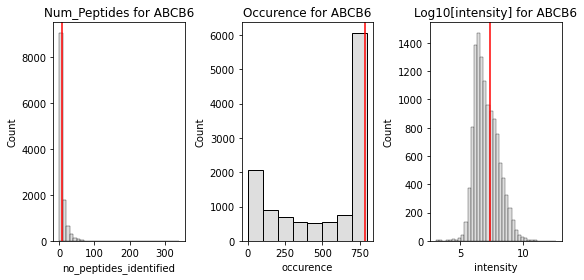

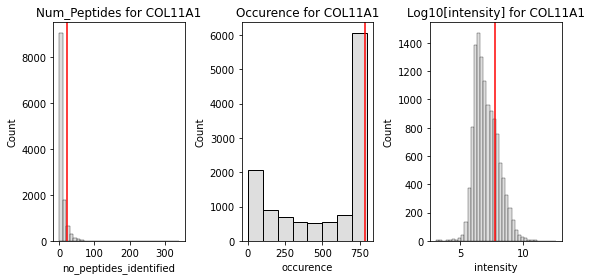

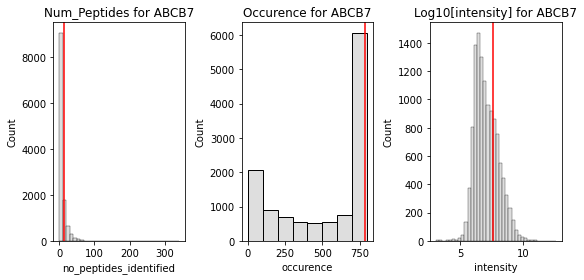

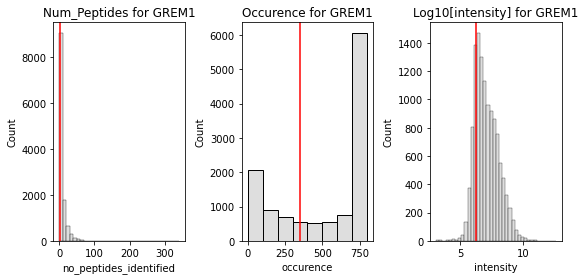

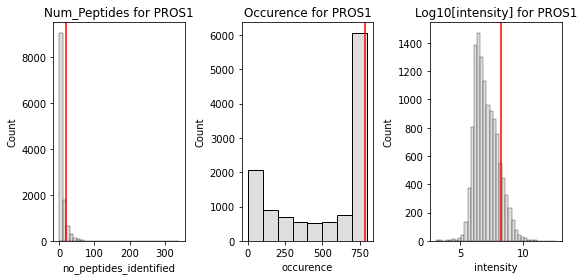

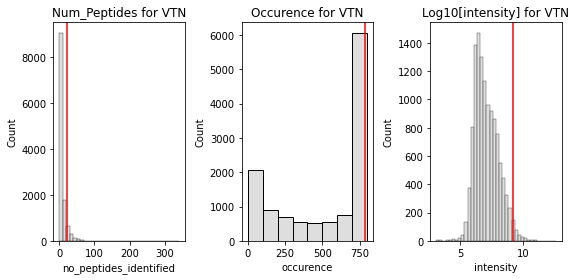

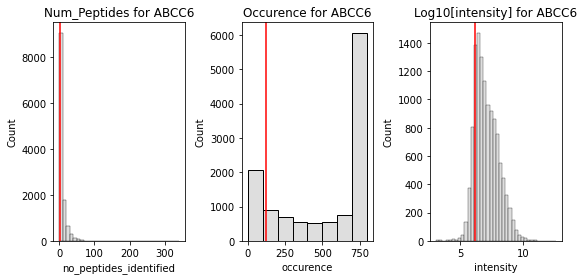

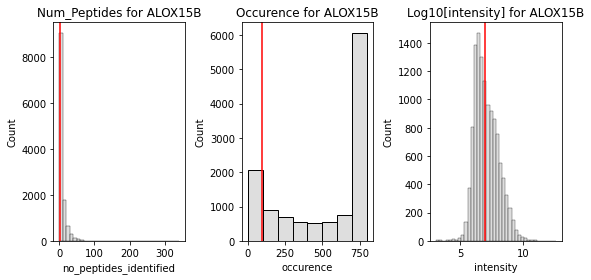

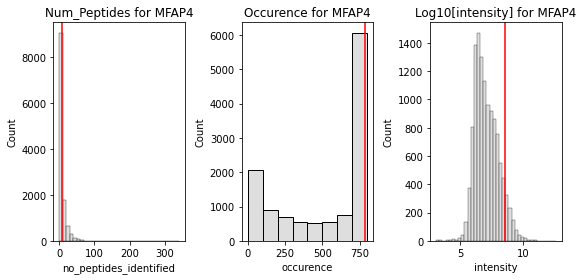

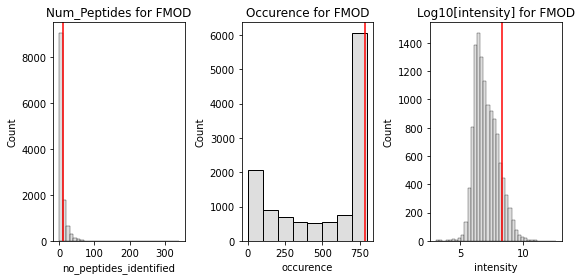

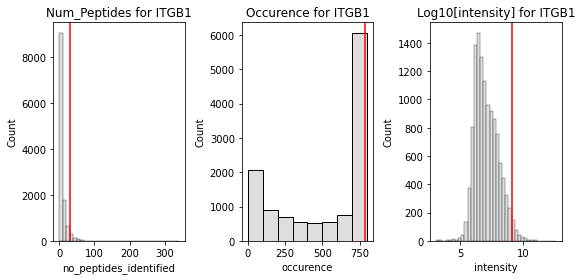

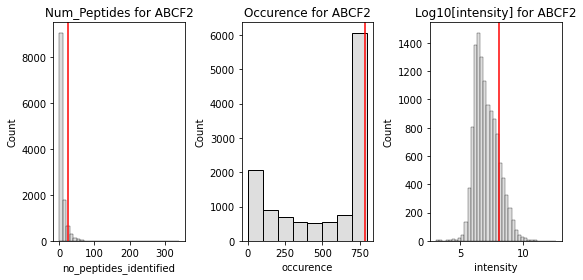

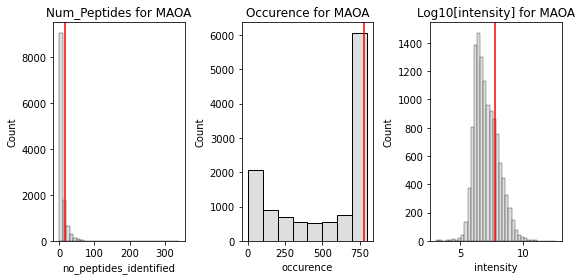

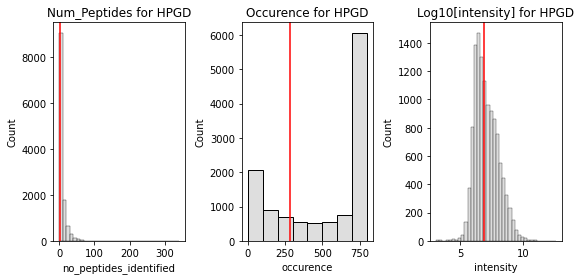

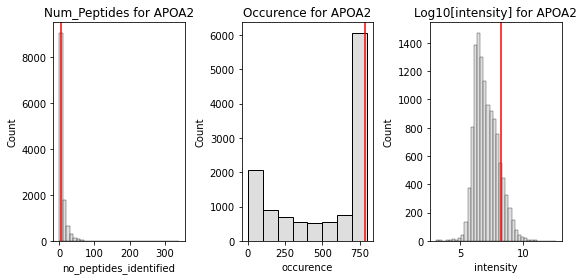

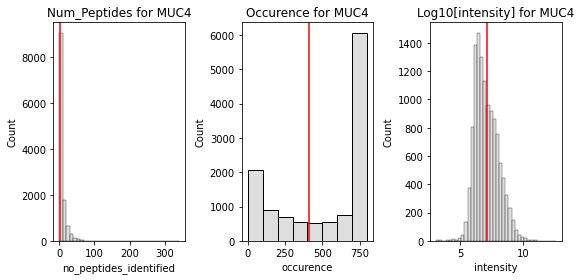

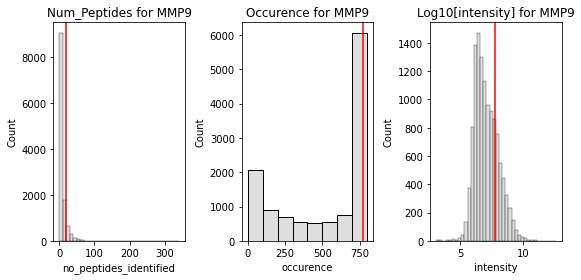

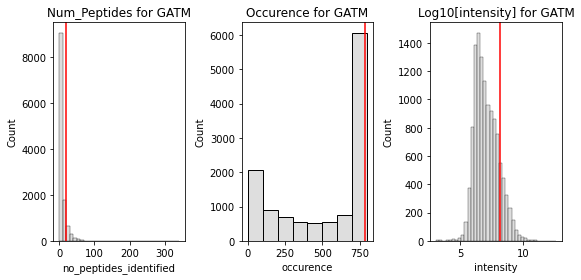

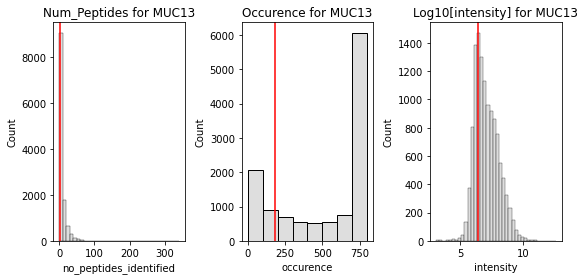

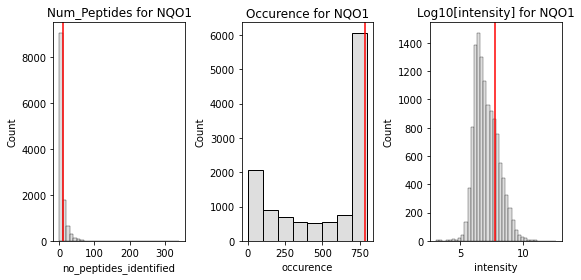

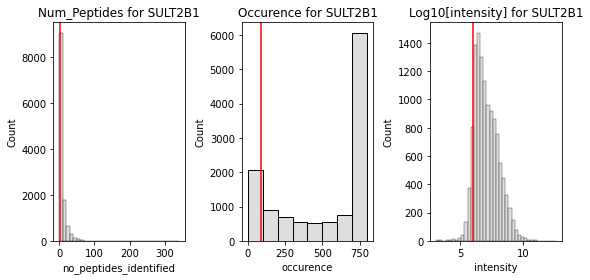

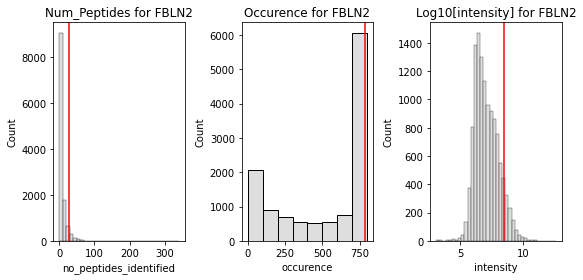

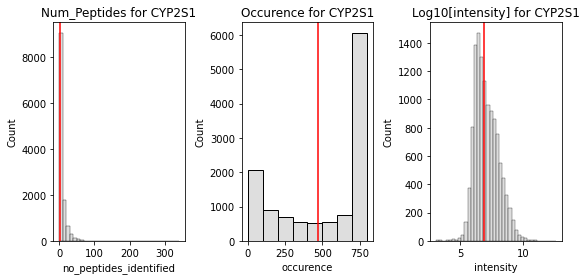

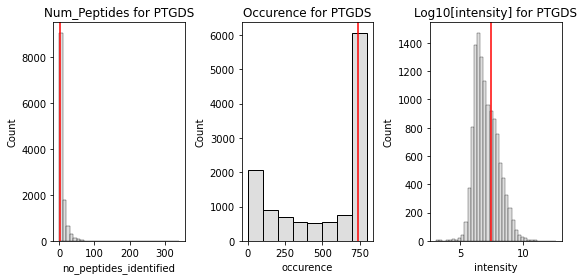

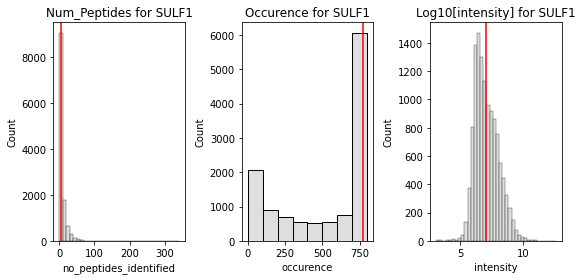

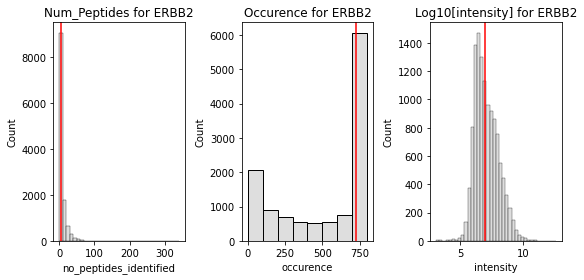

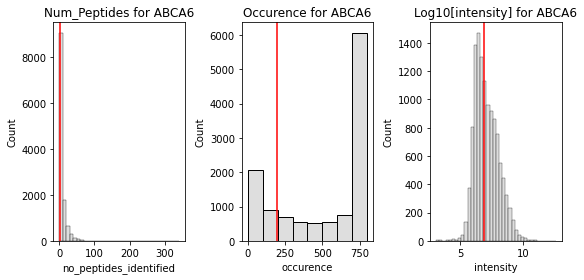

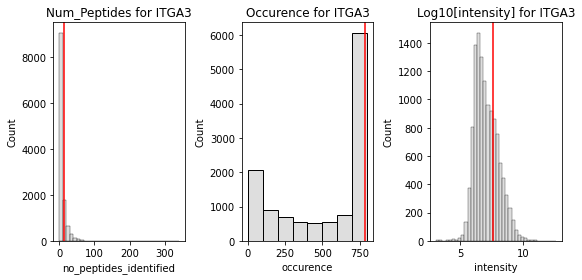

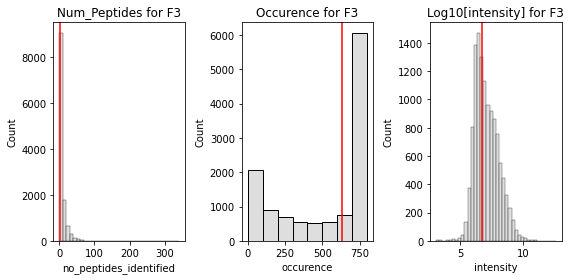

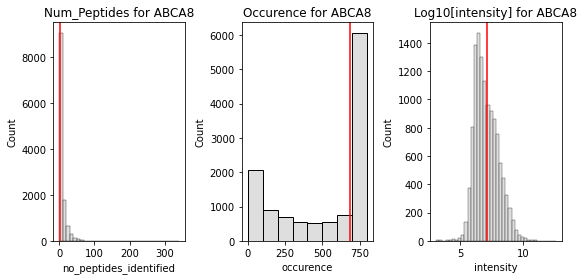

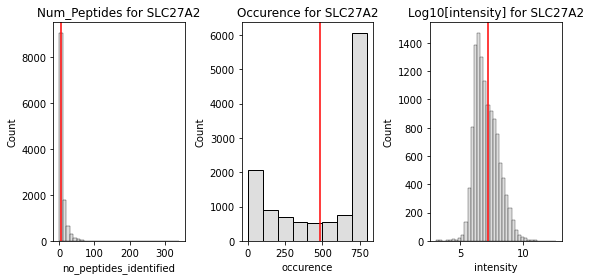

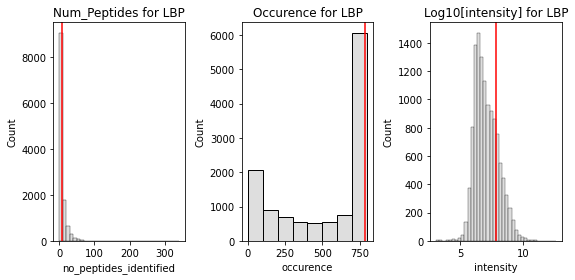

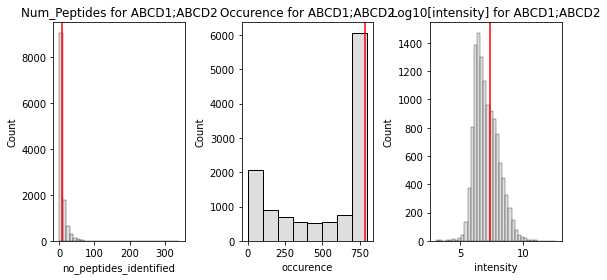

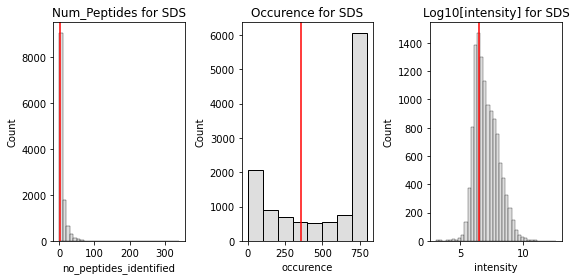

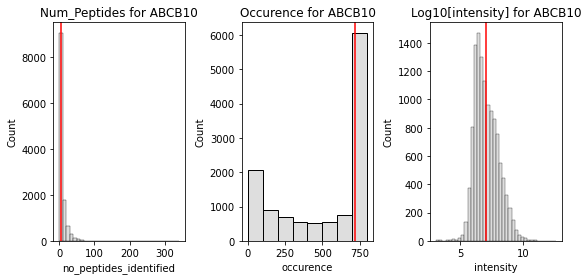

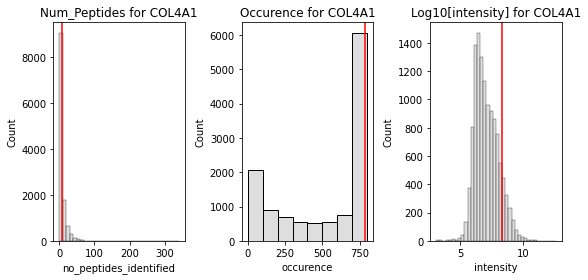

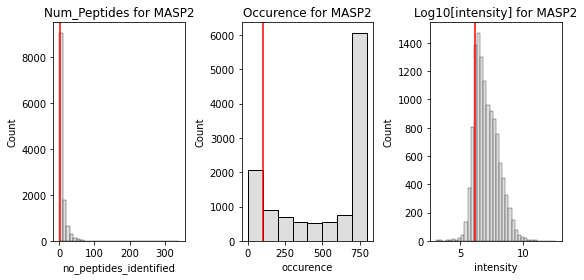

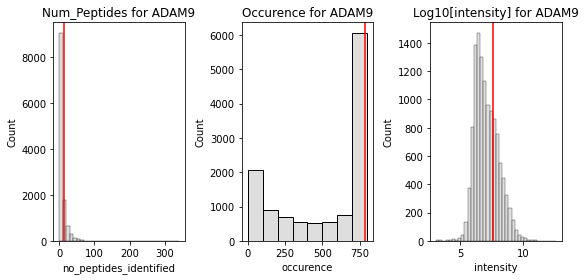

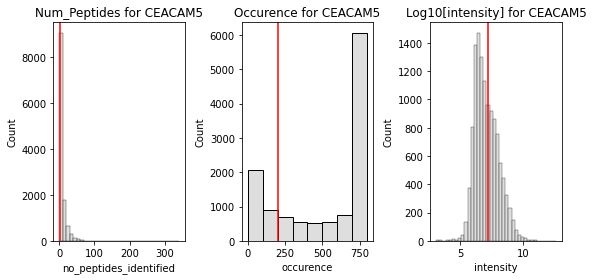

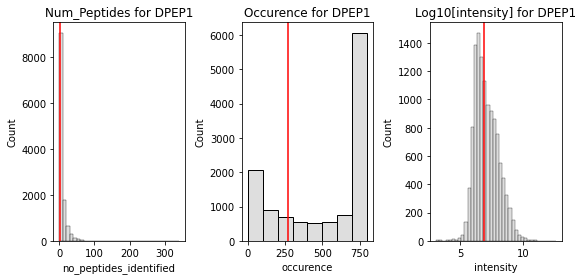

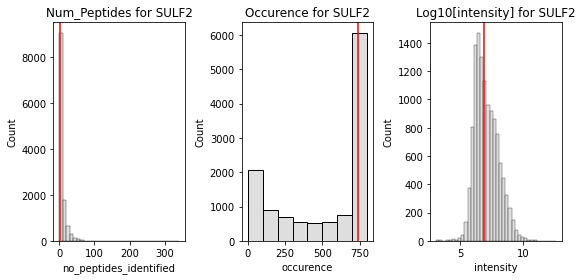

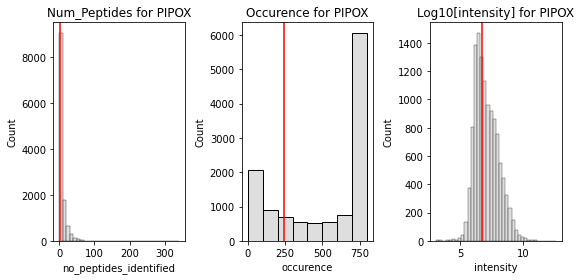

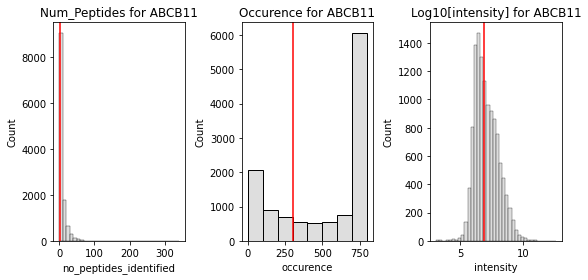

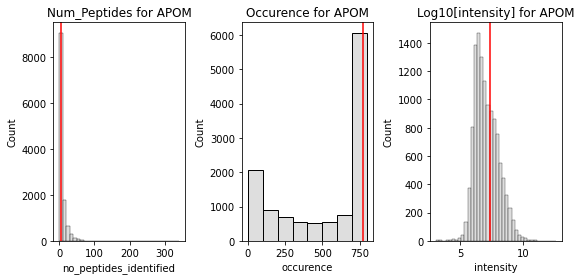

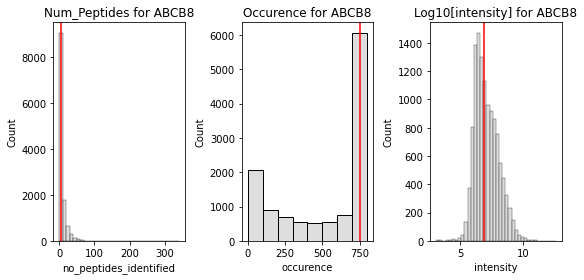

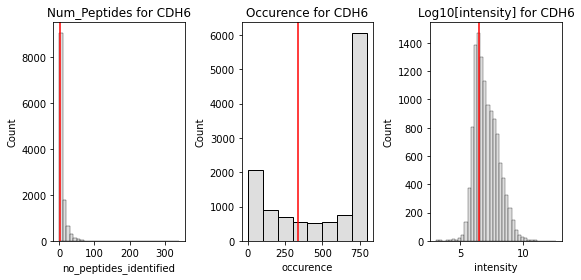

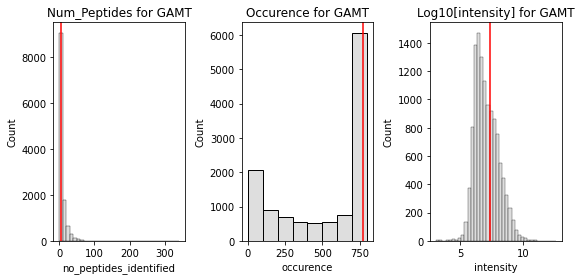

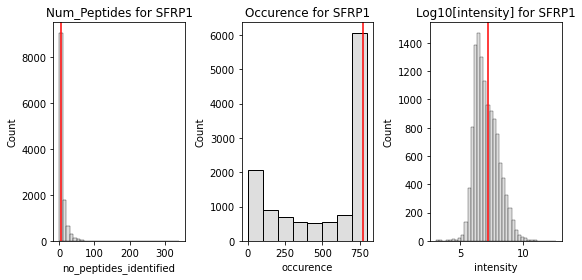

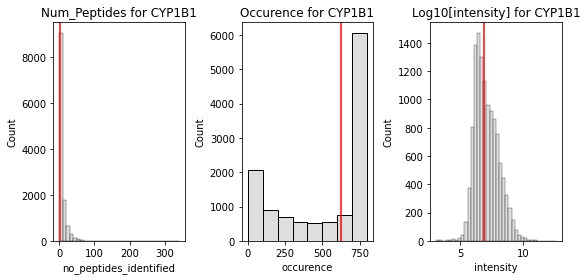

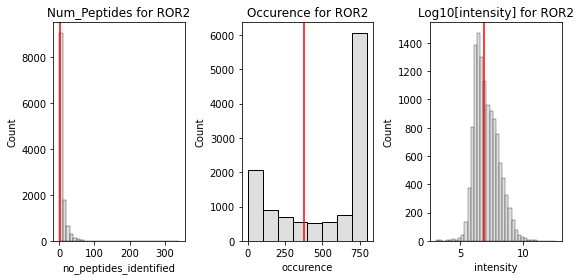

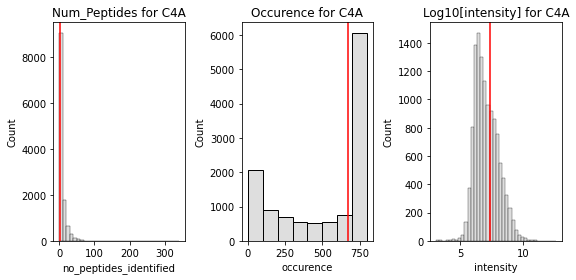

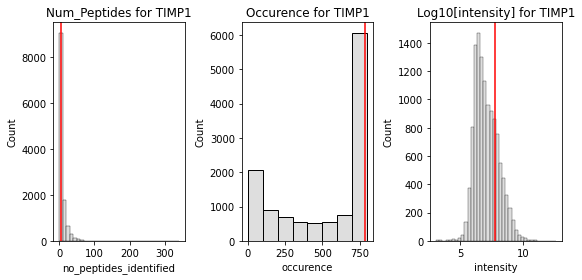

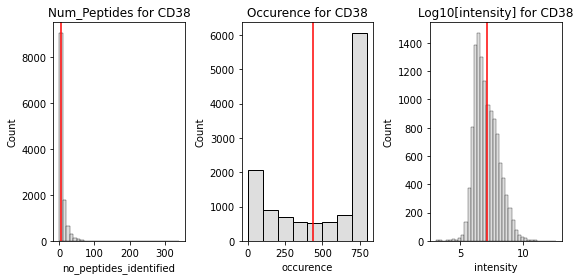

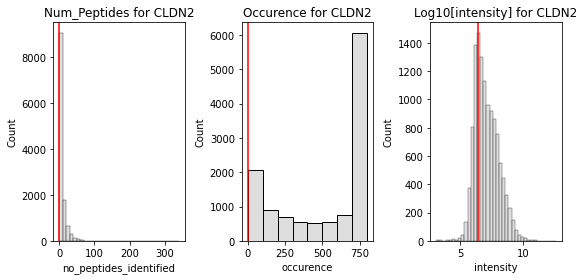

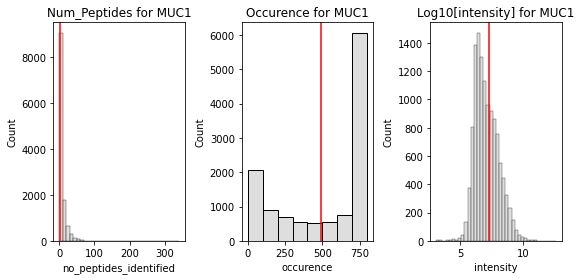

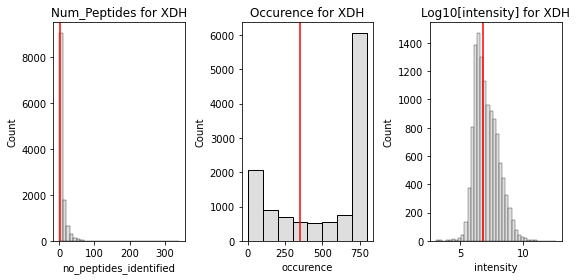

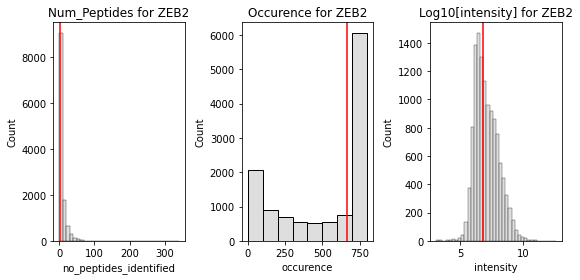

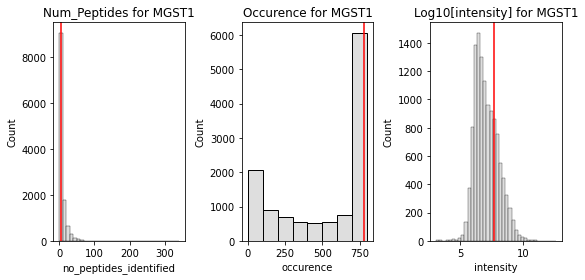

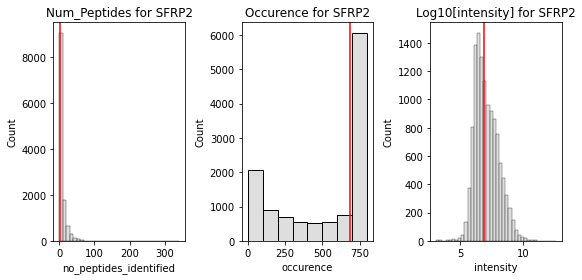

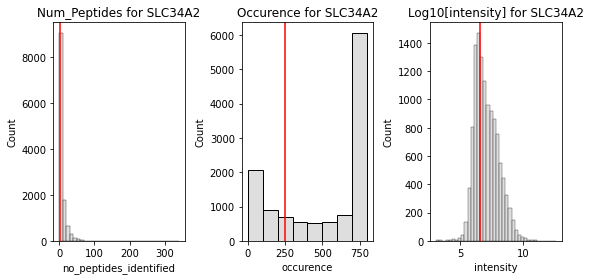

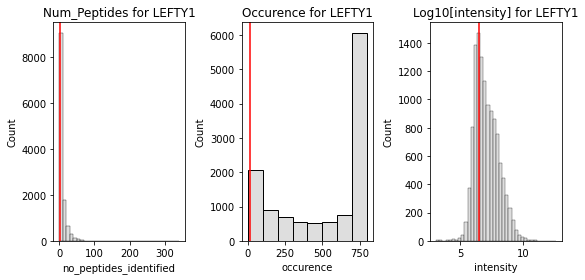

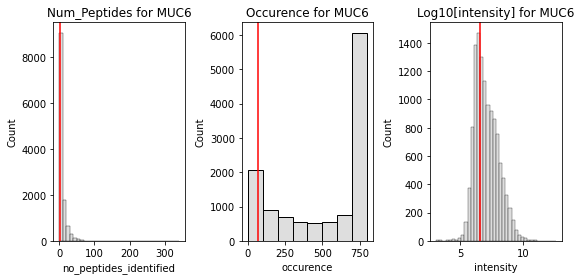

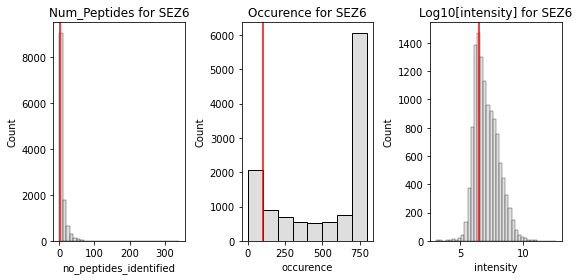

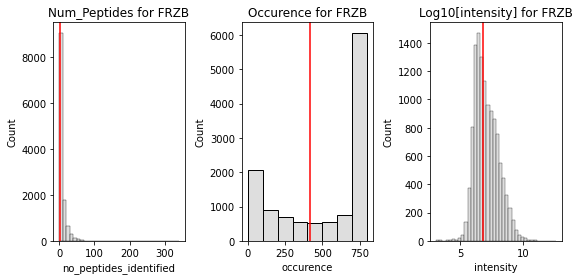

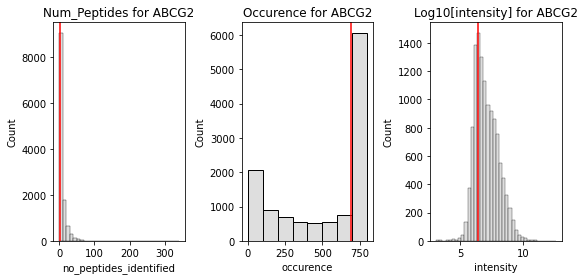

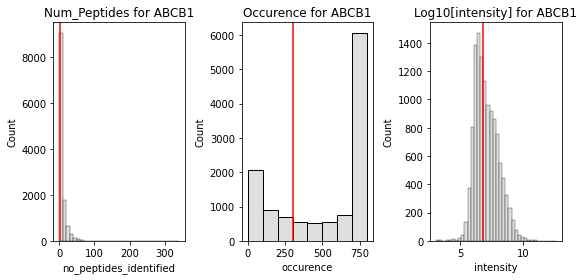

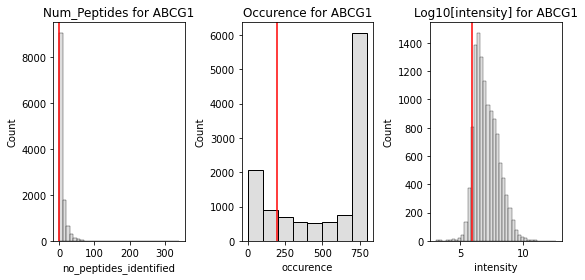

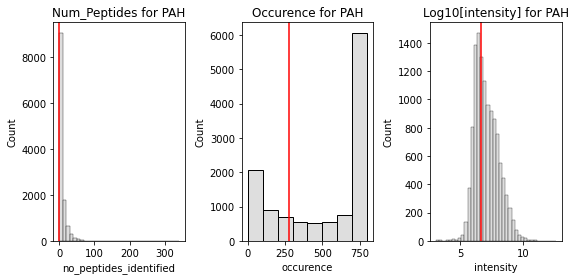

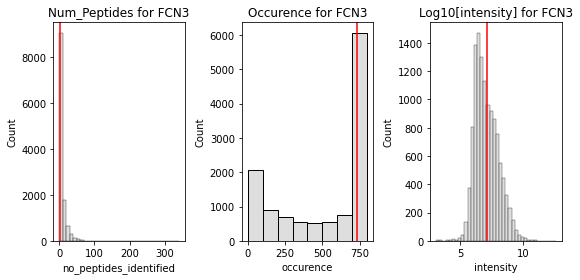

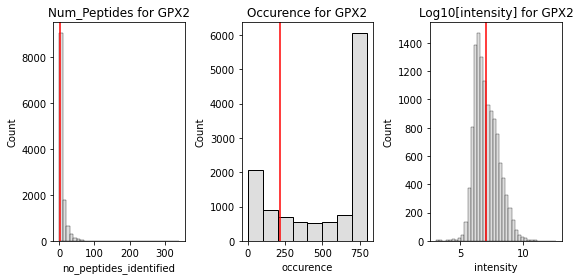

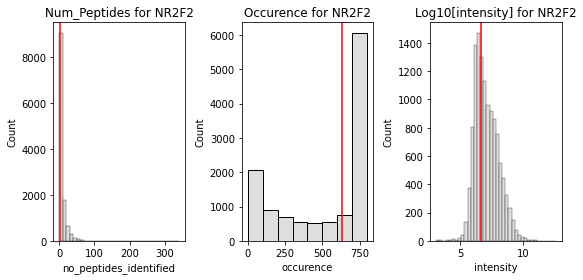

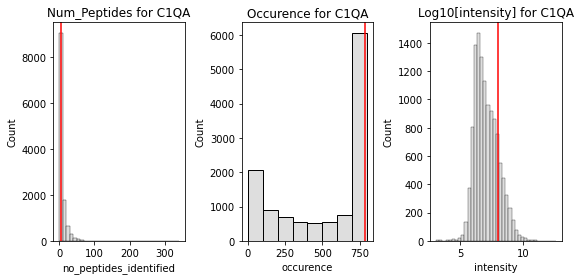

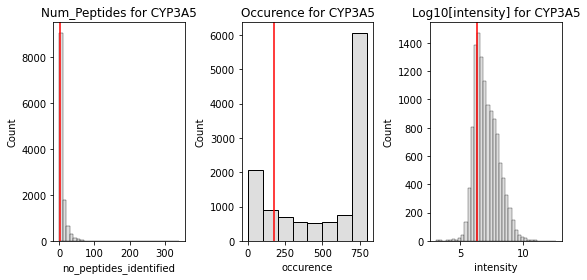

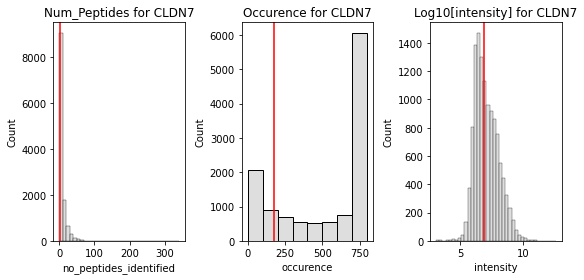

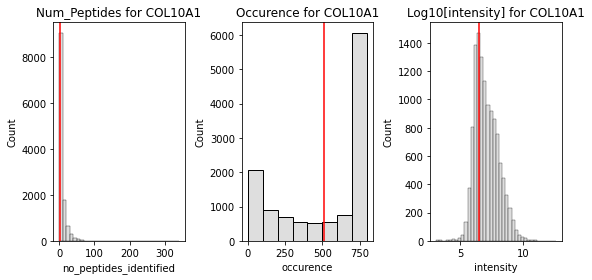

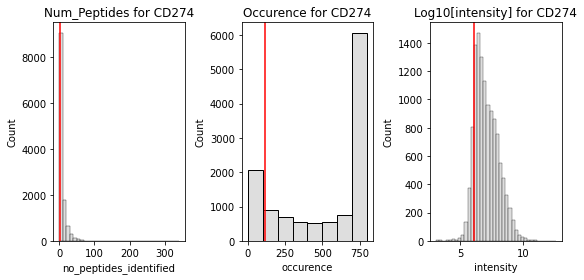

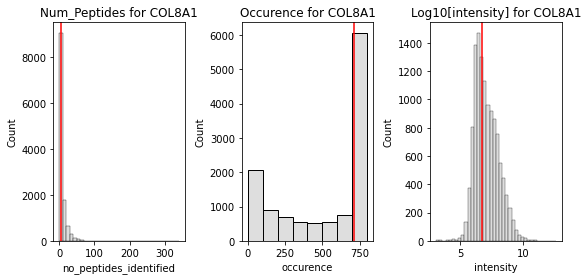

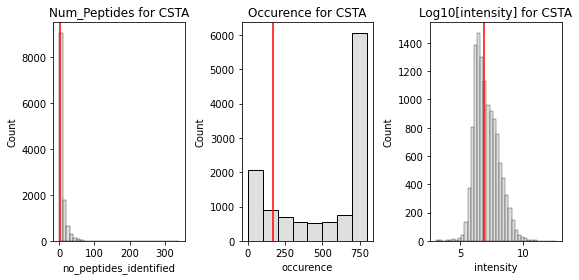

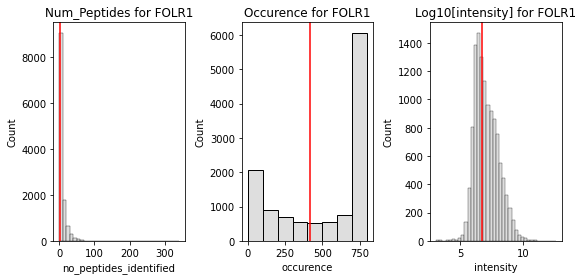

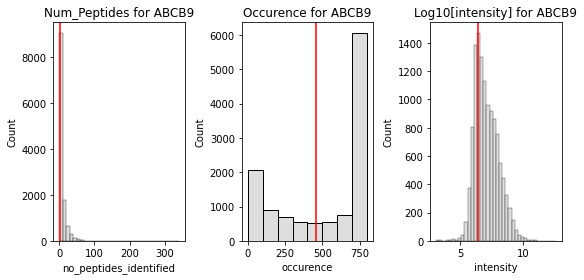

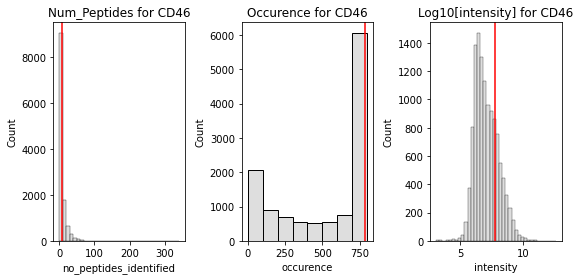

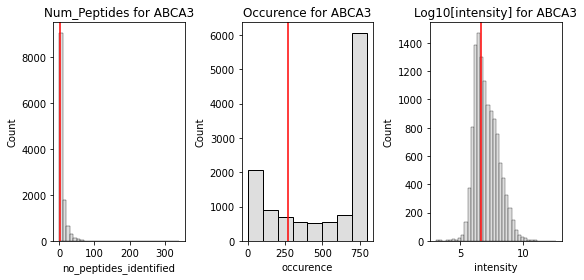

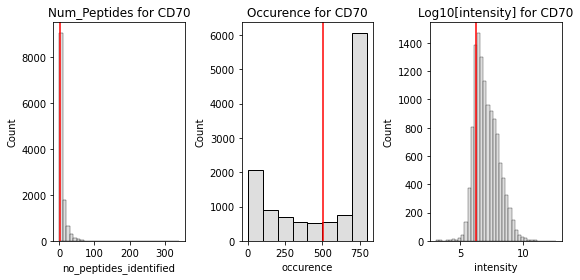

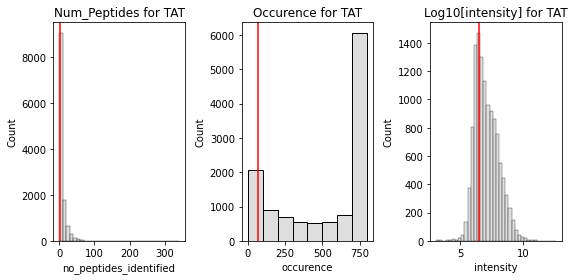

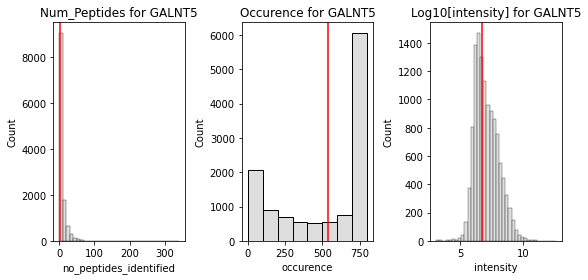

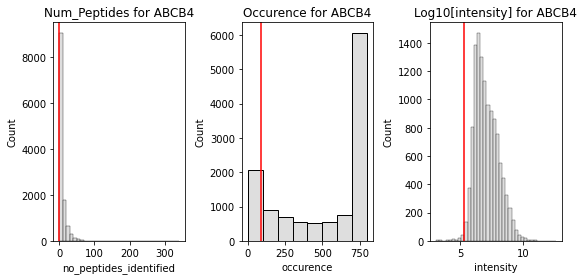

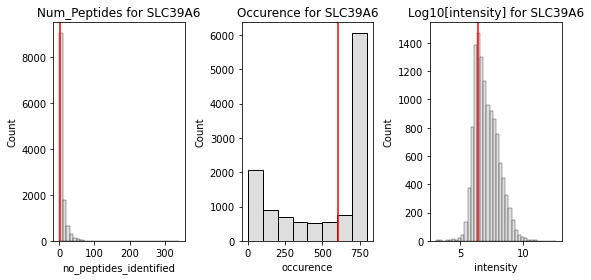

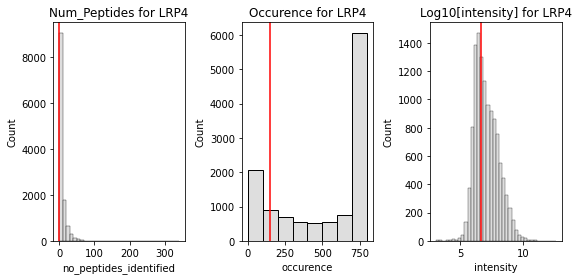

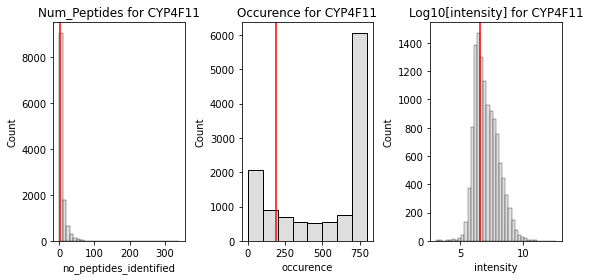

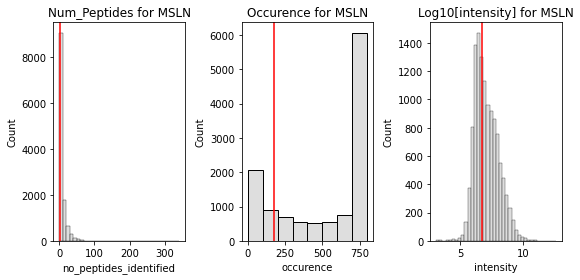

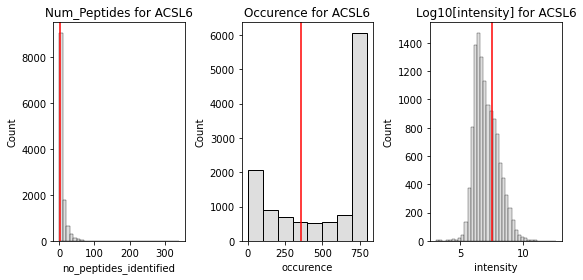

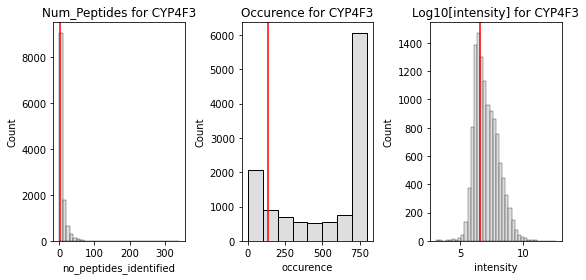

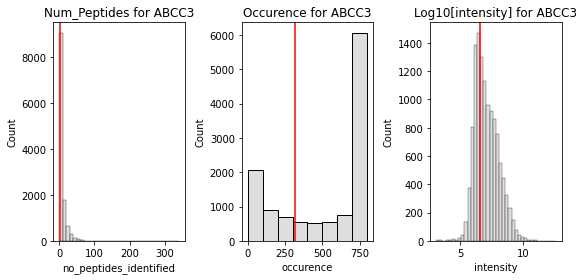

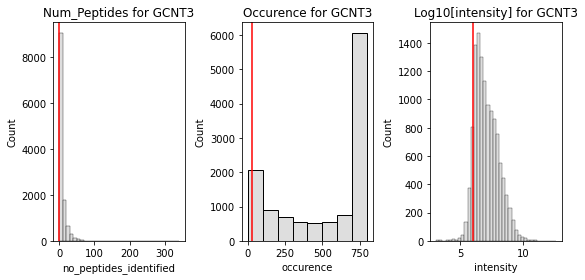

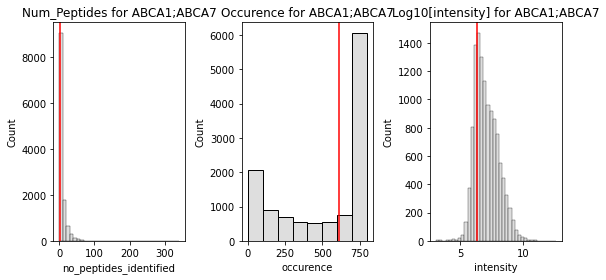

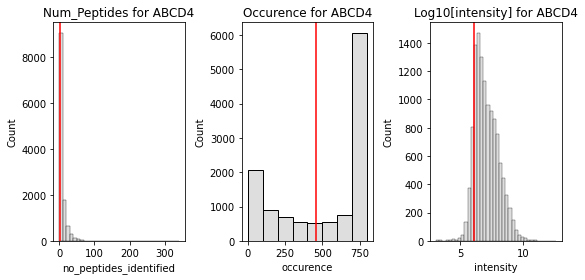

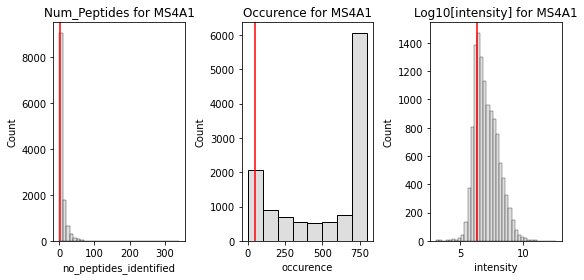

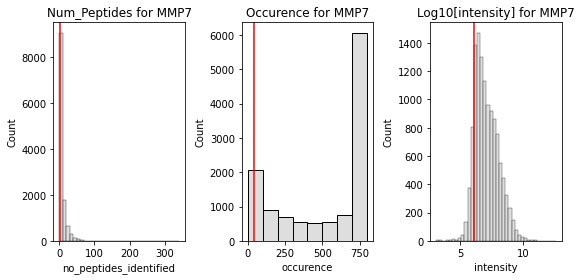

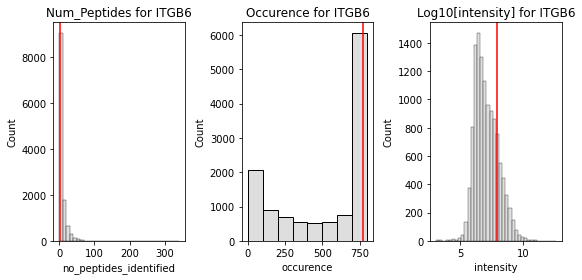

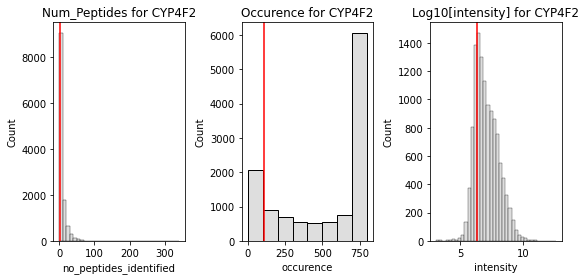

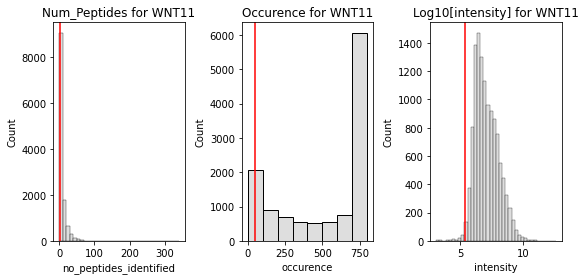

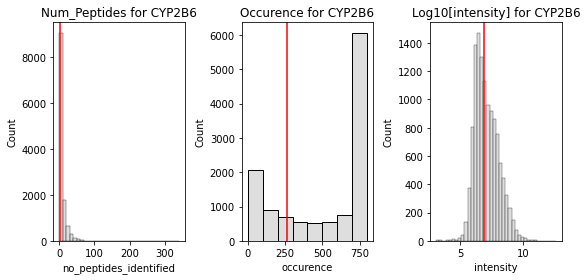

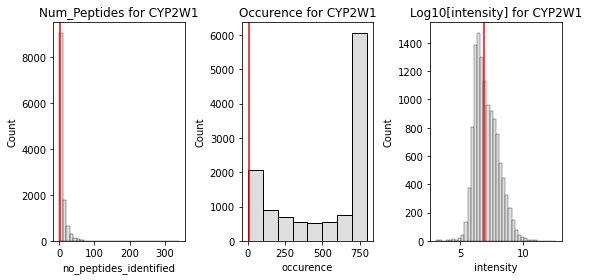

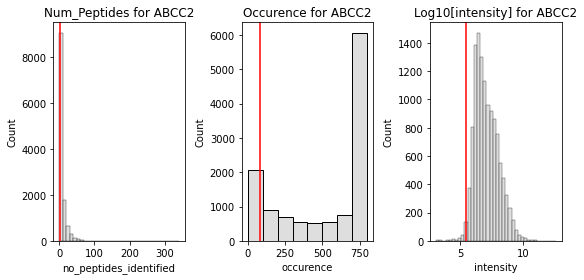

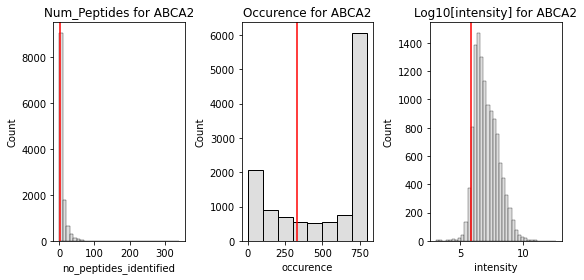

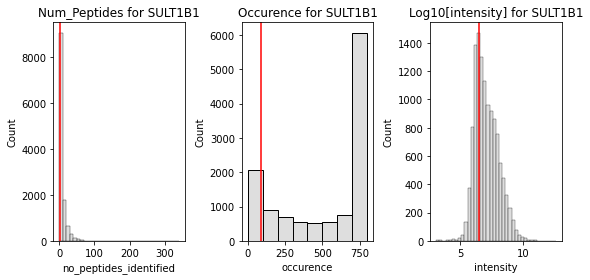

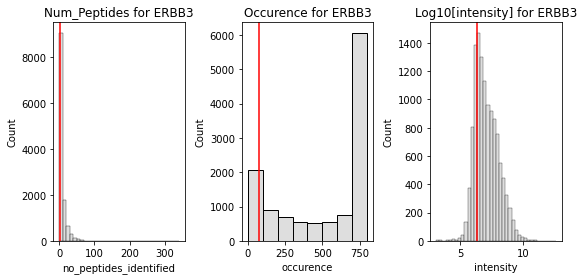

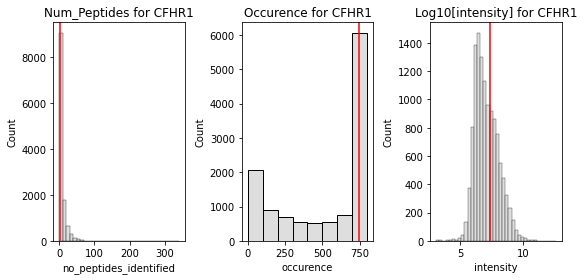

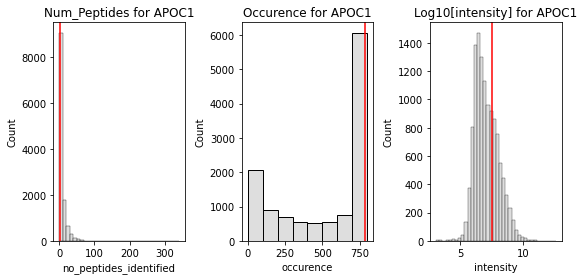

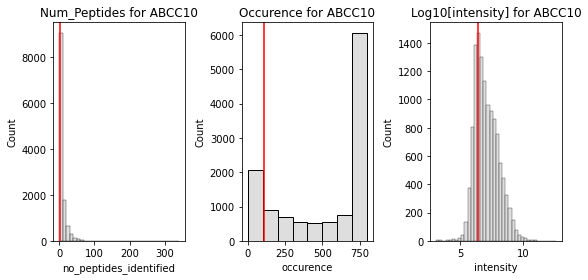

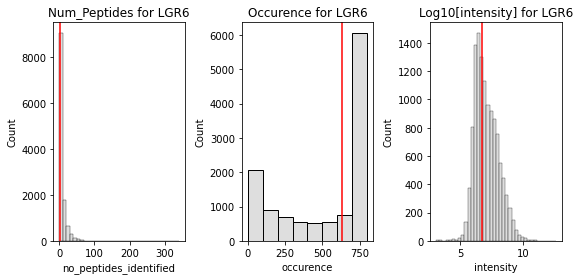

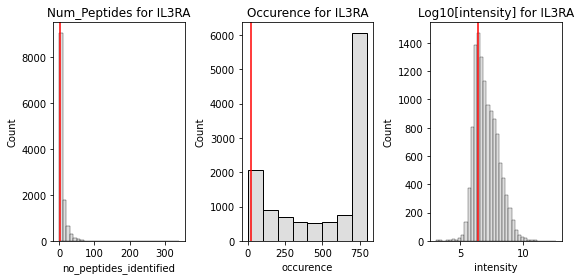

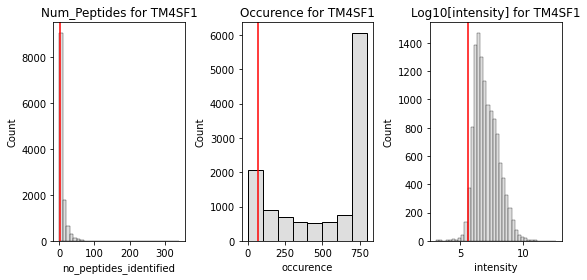

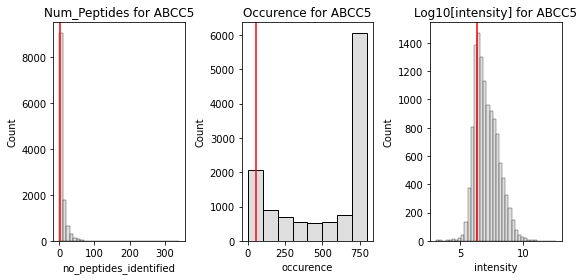

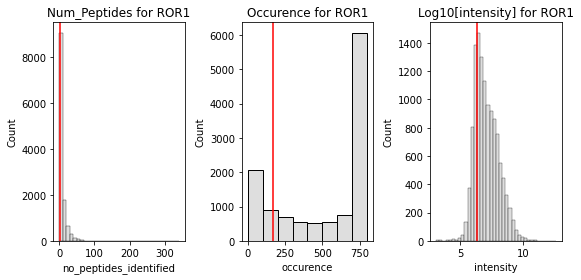

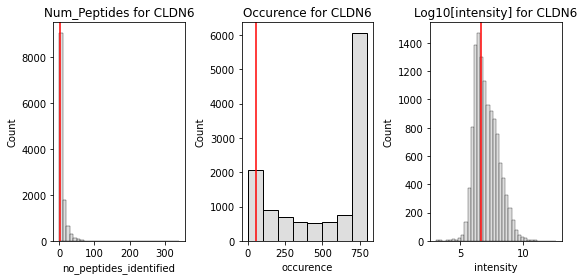

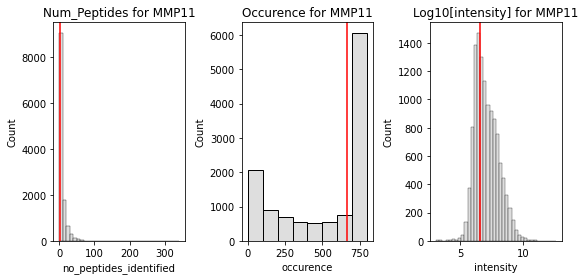

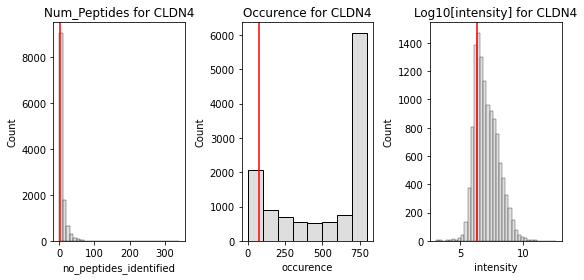

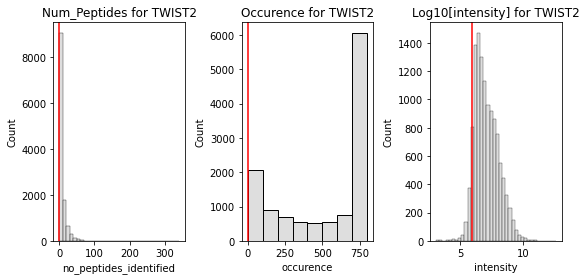

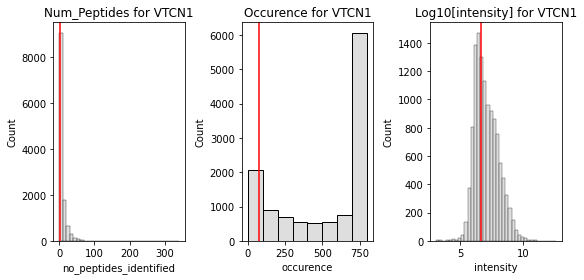

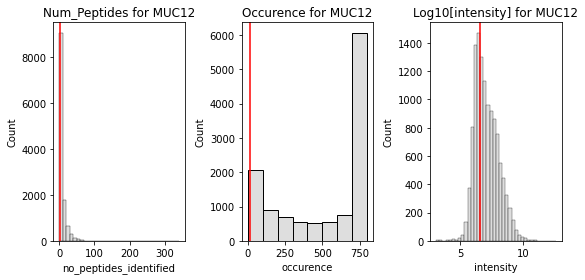

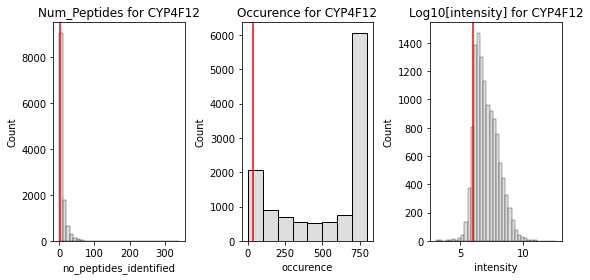

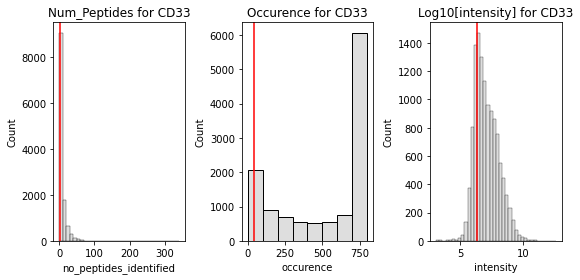

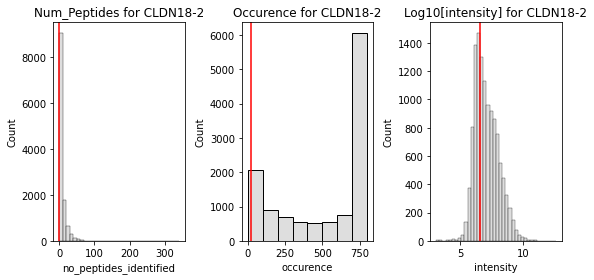

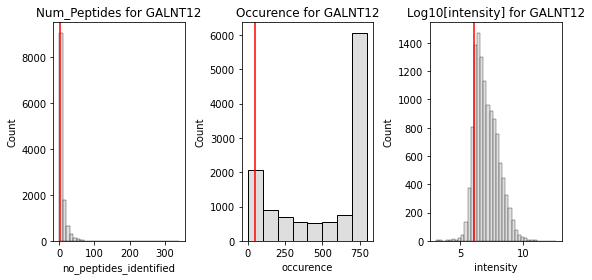

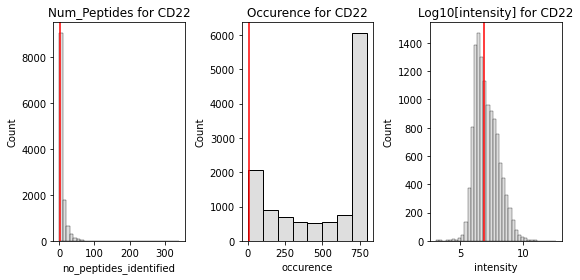

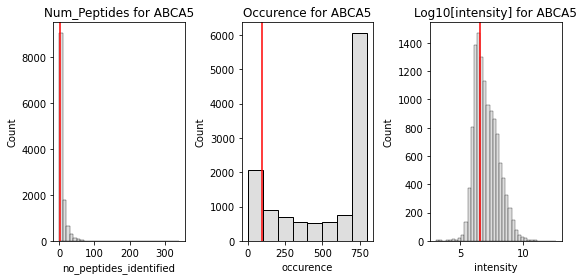

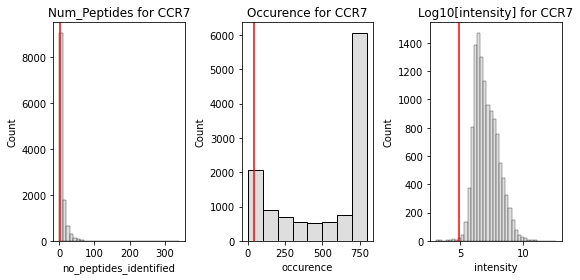

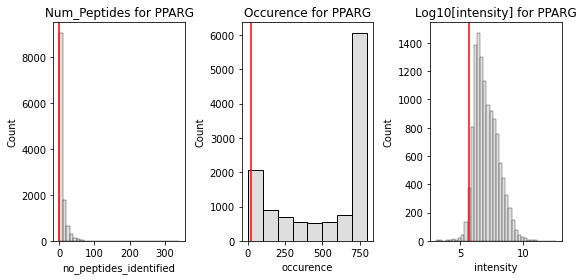

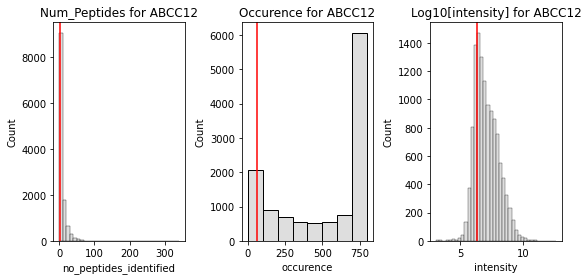

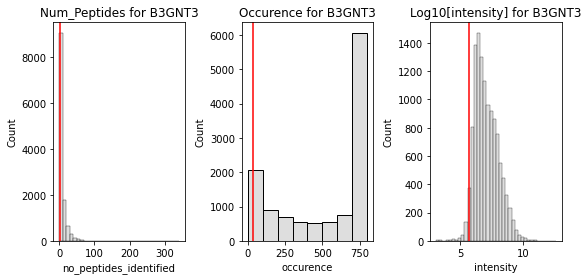

In [15]:

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
with PdfPages('/home/amir/Desktop/Annika_files/Biomarker.pdf') as pdf_pages:
        subset = main_subset.copy().reset_index()
        color = 'red'

        for i in range(len(subset)):
                protein = subset['protein_names'][i]
                
                no_pep = int(subset['no_peptides_identified'][subset['protein_names'] == protein])
                intensity = float(subset['intensity'][subset['protein_names'] == protein])
                occurence = int(subset['occurence'][subset['protein_names'] == protein])

                figu = plt.figure(i)
                plt.rcParams["figure.figsize"] = [8, 4]
                plt.rcParams["figure.autolayout"] = True
                fig, axes = plt.subplots(1,3)

                # plot heatmap
                im1 = sns.histplot(data=all_data, x="no_peptides_identified",binwidth=10,color='lightgrey',ax=axes[0])
                im1.axvline(x = no_pep, 
                        color = color,
                        ymin = 0, # Bottom of the plot
                        ymax = 1) # Top of the plot
                im1.set(title = f'Num_Peptides for {protein}')

                im2 =sns.histplot(data=all_data, x="occurence",binwidth=100,color='lightgrey',ax=axes[1])
                im2.axvline(x = occurence, 
                        color = color,
                        ymin = 0, # Bottom of the plot
                        ymax = 1) # Top of the plot

                im2.set(title = f'Occurence for {protein}')

                im3 =sns.histplot(data=all_data, x="intensity",binwidth=0.25,color='lightgrey',ax=axes[2])
                im3.axvline(x = intensity, 
                        color = color,
                        ymin = 0, # Bottom of the plot
                        ymax = 1) # Top of the plot
                        
                im3.set(title = f'Log10[intensity] for {protein}')
                fig.subplots_adjust(wspace=0.05, hspace=0)
                mappable = im1.get_children()[0]
                #fig.colorbar(mappable, ax = [patient,celllines],orientation = 'vertical')
                #ps_names.to_excel('/home/amir/Desktop/Annika_files/pseudo_names.xlsx')
                #plt.savefig('/home/amir/Desktop/Annika_files/TUPAC_IFN_EGFR.svg')
                #plt.show()
                pdf_pages.savefig(figu)
